# Practice sessions - Course 1 and Course 3  
## CART Trees and Random Forests - Jean‐Michel POGGI  
### Master 2 Course in Statistics  
### Universidad de la República – Facultad de Ingeniería, Montevideo, Uruguay
### February 2018 

#### Guide for the practice sessions with the companion scenario, the documentation [cran.r-project.org/web/packages/VSURF/index.html](cran.r-project.org/web/packages/VSURF/index.html) and the two articles: [journal.r-project.org/archive/2015-2/genuer-poggi-tuleaumalot.pdf](journal.r-project.org/archive/2015-2/genuer-poggi-tuleaumalot.pdf) [hal-descartes.archives-ouvertes.fr/hal-01387654v2](hal-descartes.archives-ouvertes.fr/hal-01387654v2)

---

> - **Student:** Guzmán López Orrego
> - **Contact:** guzilop@gmail.com
> - **Source code available at:** [github/guzmanlopez](https://github.com/guzmanlopez/ACRRF_course)
> - **Online document available at:** [Jupyter Notebook](https://github.com/guzmanlopez/ACRRF_course/blob/master/trabajo-final.ipynb)

---

## 1. Data

### 1.1. Load the library **kernlab**

> The [**kernlab**](https://cran.r-project.org/web/packages/kernlab/kernlab.pdf 'kernlab pdf manual') library in `R` will be used only to load the **spam** dataset.

In [2]:
# Load library
library(kernlab)

### 1.2. Load the dataset **spam** in R and build the dataframes of learning and test sets (the first will be used for designing trees, the second for evaluating errors)

- **Explore the **spam** dataset**

In [3]:
# Load data
data(spam)

In [539]:
# Explore the spam dataset
# ?spam

In [5]:
# See the spam dataset structure
str(spam)

'data.frame':	4601 obs. of  58 variables:
 $ make             : num  0 0.21 0.06 0 0 0 0 0 0.15 0.06 ...
 $ address          : num  0.64 0.28 0 0 0 0 0 0 0 0.12 ...
 $ all              : num  0.64 0.5 0.71 0 0 0 0 0 0.46 0.77 ...
 $ num3d            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ our              : num  0.32 0.14 1.23 0.63 0.63 1.85 1.92 1.88 0.61 0.19 ...
 $ over             : num  0 0.28 0.19 0 0 0 0 0 0 0.32 ...
 $ remove           : num  0 0.21 0.19 0.31 0.31 0 0 0 0.3 0.38 ...
 $ internet         : num  0 0.07 0.12 0.63 0.63 1.85 0 1.88 0 0 ...
 $ order            : num  0 0 0.64 0.31 0.31 0 0 0 0.92 0.06 ...
 $ mail             : num  0 0.94 0.25 0.63 0.63 0 0.64 0 0.76 0 ...
 $ receive          : num  0 0.21 0.38 0.31 0.31 0 0.96 0 0.76 0 ...
 $ will             : num  0.64 0.79 0.45 0.31 0.31 0 1.28 0 0.92 0.64 ...
 $ people           : num  0 0.65 0.12 0.31 0.31 0 0 0 0 0.25 ...
 $ report           : num  0 0.21 0 0 0 0 0 0 0 0 ...
 $ addresses        : num  0 0.14 1.75 0 0

> To continue exploring the **spam** dataset, the **tidyverse** and the **ggridges** libraries will be loaded into the `R` environment. They will be used to manipulate and visualize data. 

In [6]:
# Load libraries
library(tidyverse)
library(ggridges)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1.9000     ✔ purrr   0.2.4     
✔ tibble  1.4.2          ✔ dplyr   0.7.4     
✔ tidyr   0.8.0          ✔ stringr 1.3.0     
✔ readr   1.1.1          ✔ forcats 0.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::alpha() masks kernlab::alpha()
✖ purrr::cross()   masks kernlab::cross()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()


> Establish manual colors from Monokai palette to use in plots and as a general color theme.

In [7]:
# Create manual colors
lightgray <- "#75715E"
gray <- "#4D4D4D"
darkgray <- "#272822"
red <- "#C72259"
orange <- "#C97C16"
green <- "#81B023"
purple <- "#8F66CC"
blue <- "#53A8BD"

- **Create boxplots of variables**

> Create the function called `boxplotOfSpamVars` to build boxplots of any variable/s selected from the spam dataset

In [531]:
# Create function
boxplotOfSpamVars <- function(vars) {
    
    # Reshape the spam data to make a boxplot 
    spam.gather <- spam %>% 
                        select(c("type", vars)) %>% 
                            gather(key = "var", value = "values", -type)

    # Create a boxplot of every variable separeted by the variable type (spam and nonspam)
    spam.boxplot <- ggplot() + 
    geom_boxplot(data = spam.gather, aes(x = var, y = values, color = type), 
                 lwd = 0.25, alpha = 0.5) + 
    scale_color_manual(values = c(green, red), name = "type")
    
    # Create faceting
    spam.boxplot + facet_grid(var ~ ., scales = "free")
}


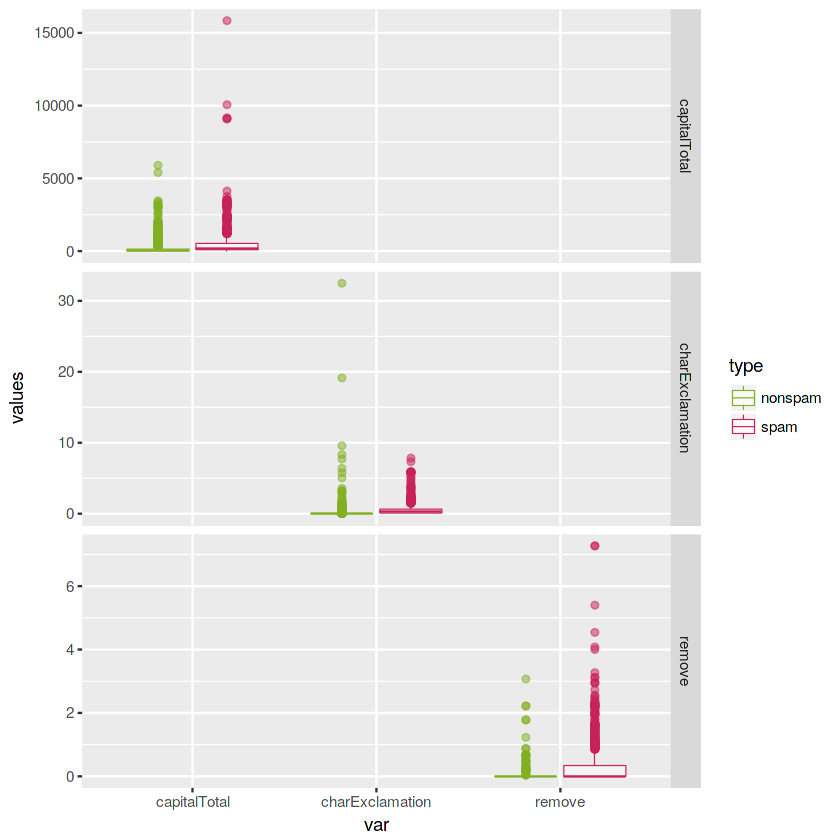

In [530]:
# Explore charExclamation and remove variables
boxplotOfSpamVars(vars = c("charExclamation", "remove", "capitalTotal"))

> It seems that the character exclamation symbol (*charExclamation*), the total number of capital letters (*capitalTotal*) and the presence of the word *remove* are more frequent in *spam* mails than in *nonspam* mails. 

- **Create density plots of standarized variables to compare their distributions. 1) Center variables by subtracting their means (omitting NAs). 2) Divide the centered variables by their standard deviations**

In [10]:
# Standardization of all the predictor variables
spam.norm <- as.data.frame(scale(spam[, -58]))
spam.norm$type <- spam$type

In [11]:
# Manipulate the standarized spam.norm data to allow making a density plot of all the variables 
spam.norm.gather <- spam.norm %>% 
                        gather(key = "var", value = "values", -type) %>%  # reshape
                            group_by(var, type)  # group by columns 'var' and 'type'

# Pint the first 6 rows of the new manipulated data.frame
head(spam.norm.gather)

type,var,values
spam,make,-0.3423965
spam,make,0.3453219
spam,make,-0.1459055
spam,make,-0.3423965
spam,make,-0.3423965
spam,make,-0.3423965


Picking joint bandwidth of 0.0332
Warning message:
“Removed 15243 rows containing non-finite values (stat_density_ridges).”

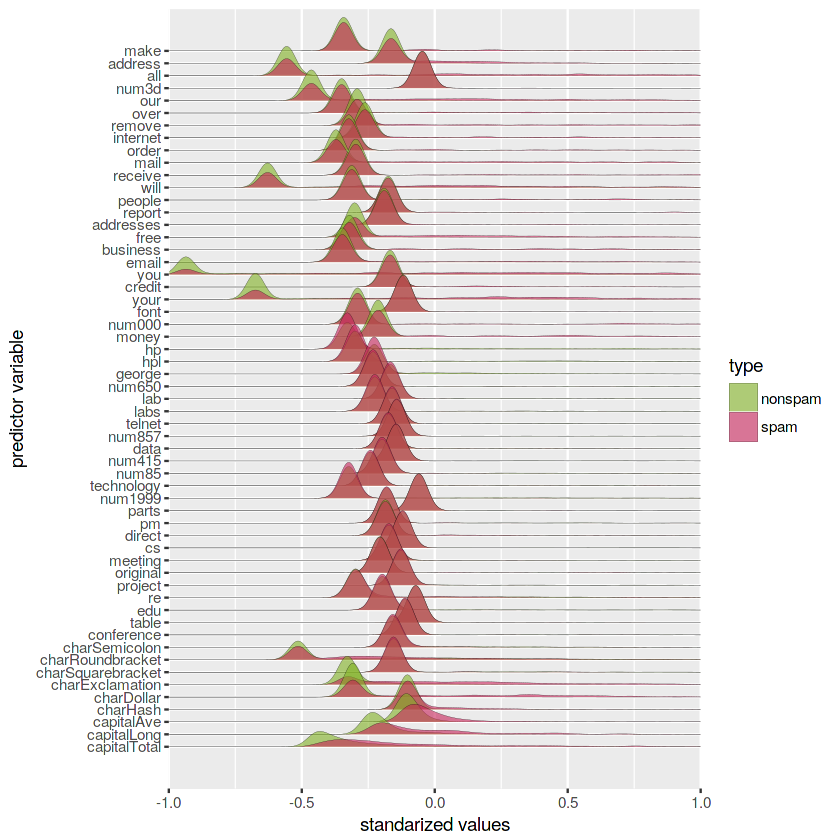

In [532]:
# Create a ggplot of standarized variables densities
ggplot(spam.norm.gather) +
geom_density_ridges(aes(x = values,
                        y = factor(as.character(spam.norm.gather$var), 
                                   levels = rev(unique(as.character(spam.norm.gather$var)))),
                        fill = type), alpha = 0.6, lwd = 0.05, scale = 3) +
scale_y_discrete(name = "predictor variable", expand = c(0.06, 0)) +
scale_x_continuous(name = "standarized values", expand = c(0, 0), limits = c(-1, 1)) +
scale_fill_manual(values = c(green, red), name = "type")

> Looking at the above figure, it seems that the variables *capitalAve*, *capitalLong* and *capitalTotal* have markedly different peaks for *spam* and *nonspam* distributions.

- **Build dataframes by sampling**

In [13]:
# Set seed
set.seed(20)

# Add id column to spam data.frame
spam$ID <- 1:nrow(spam)

# Train data.frame
train <- spam %>% sample_frac(size = 0.70, replace = FALSE) # 70% of data for train

# Test data.frame
test <- spam[-train$ID, ] # 30% of the data for test

# Remove ID column
spam <- spam[, -59]
train <- train[, -59]
test <- test[, -59]

> The learn dataset is the object named `train` dataset

## 2. CART trees

### 2.1. Load the library **rpart**

In [14]:
library(rpart)

> The [**rpart**](https://cran.r-project.org/web/packages/rpart/rpart.pdf 'rpart pdf manual') is an `R` library for "Recursive partitioning for classification, regression and survival trees. It is an implementation of most of the functionality of the 1984 book by Breiman, Friedman, Olshen and Stone. It also includes similar Fortran code in the source."

### 2.2. Compute the default tree provided by **rpart**

In [15]:
# Default rpart tree with train data
fit.train.def <- rpart(type ~ ., data = train, method = 'class')

> Plot the default tree using the library [**rpart.plot**](http://www.milbo.org/rpart-plot/prp.pdf) for better tree visualization.

In [16]:
# Load library
library("rpart.plot")

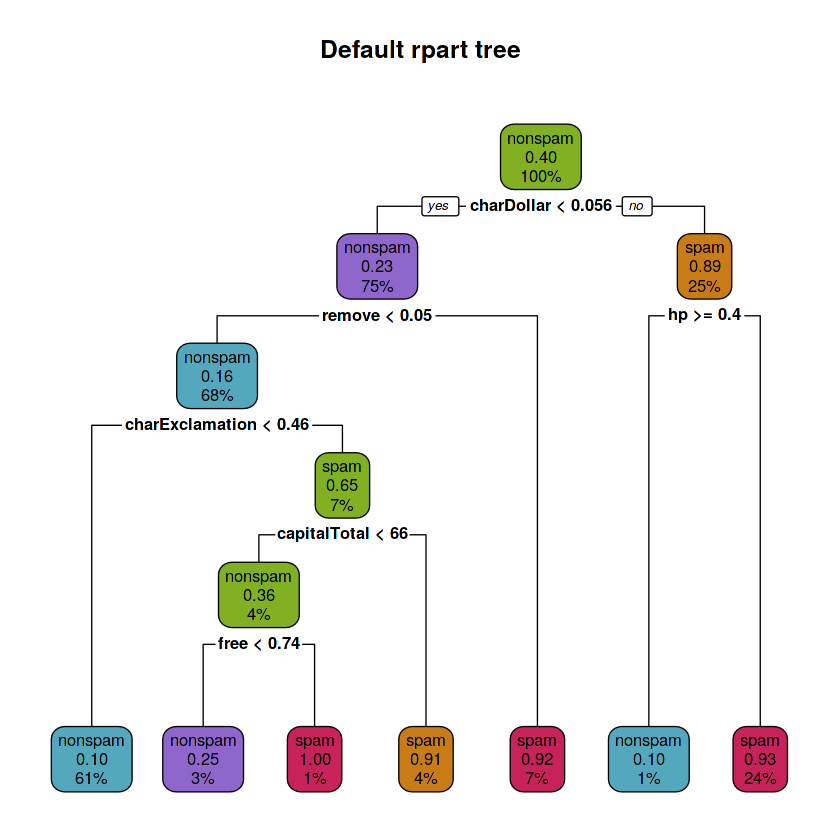

In [17]:
# Plot tree
rpart.plot(fit.train.def, main = "Default rpart tree", 
           box.palette = rev(c(red, orange, green, purple, blue)), type = 2)

Each node of the binary model tree shows:

- the predicted class (*spam* or *nonspam*)
- the predicted probability of *spam*
- the percentage of observations in the node

In [533]:
# Depth of tree
cat("The depth of the default tree is:", 
    max(rpart:::tree.depth(as.numeric(rownames(fit.train.def$frame)))), "\n")

# Number of leaves
cat("The number of leaves is:", 
    sum(fit.train.def$frame$var == "<leaf>"), "\n")

# Variables involved in splits
cat("The splits involved the following variables: \n")
purrr::map(unique(fit.train.def$frame$var[which(fit.train.def$frame$var != "<leaf>")]),
           ~ paste(as.character(.x)))

The depth of the default tree is: 5 
The number of leaves is: 7 
The splits involved the following variables: 


[[1]]
[1] "charDollar"

[[2]]
[1] "remove"

[[3]]
[1] "charExclamation"

[[4]]
[1] "capitalTotal"

[[5]]
[1] "free"

[[6]]
[1] "hp"

> The default `rpart` tree has a depth of 5, it has 7 leaves and the splits involved 6 variables: *charDollar*, *remove*, *hp*, *charExclamation*, *capitalTotal* and *free*.
> A high frequency of dollar sign characters, *hp* word, *remove* word, exclamation sign character, *free* word and capital letters present in an e-mail means that is probably a spam e-mail.

> The tree was constructed using default `rpart` settings: following the Gini index of heterogeneity for growing the trees, 10 fold cross-validation pruning and `'class'` `method` since `type` (response variable) is categorical.

### 2.3. Build a tree of depth 1 (stump) and draw it

In [19]:
# Build tree
fit.train.d1 <- rpart(type ~ ., data = train, control = rpart.control(maxdepth = 1), 
                      method = 'class')

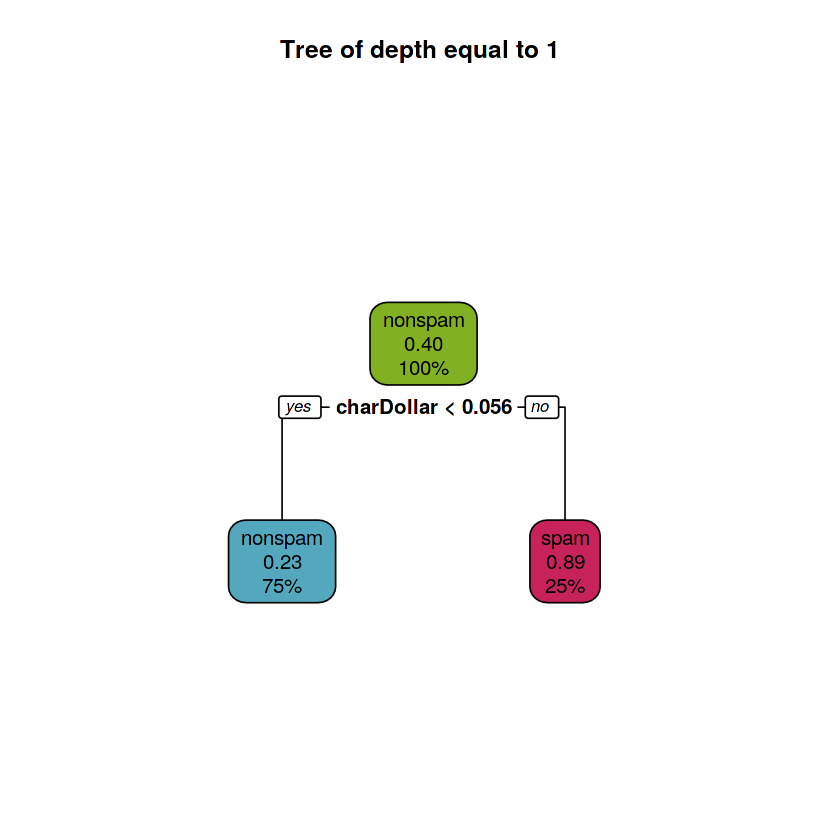

In [20]:
# Plot tree
rpart.plot(fit.train.d1, main = "Tree of depth equal to 1", 
           box.palette = rev(c(red, orange, green, purple, blue)), type = 2)

> The tree of depth equal to 1 has 2 leaves and the split involved 1 variable: *charDollar*. Many dollar sign characters present in an e-mail means that is probably (*p = 0.89*) a spam e-mail.

> The tree was constructed using some default `rpart` settings: following the Gini index of heterogeneity for growing the trees, 10 fold cross-validation pruning and `'class'` `method` since `type` (response variable) is categorical but limiting the `maxdepth` to 1. 

### 2.4. Examine splits: primary splits and surrogate splits

> Once a splitting variable and a split point for it have been decided, the observations that have missing data for this variable are estimated using the other predictor variables. `rpart` uses a variation of this to define surrogate variables.

In [21]:
# Get summary of the rpart model tree
summary(fit.train.d1)

Call:
rpart(formula = type ~ ., data = train, method = "class", control = rpart.control(maxdepth = 1))
  n= 3221 

         CP nsplit rel error    xerror       xstd
1 0.4913928      0 1.0000000 1.0000000 0.02172579
2 0.0100000      1 0.5086072 0.5610329 0.01847356

Variable importance
 charDollar      num000       money capitalLong      credit       order 
         46          16          16           8           8           7 

Node number 1: 3221 observations,    complexity param=0.4913928
  predicted class=nonspam  expected loss=0.3967712  P(node) =1
    class counts:  1943  1278
   probabilities: 0.603 0.397 
  left son=2 (2417 obs) right son=3 (804 obs)
  Primary splits:
      charDollar      < 0.0555 to the left,  improve=522.4686, (0 missing)
      charExclamation < 0.0525 to the left,  improve=512.7627, (0 missing)
      remove          < 0.01   to the left,  improve=427.5583, (0 missing)
      your            < 0.375  to the left,  improve=407.3059, (0 missing)
      free     

> The **primary splits** for the node number 1 are: *charDollar*, *charExclamation*, *remove*, *your* and *free* and the **surrogate splits** are: *num000*, *money*, *capitalLong*, *credit* and *order*. There aren't missing data in the primary splits so the surrogate splits weren't used and they don't have any split. There are five primary splits and five surrogate splits retained because those are the default values for `rpart` (*maxsurrogate = 5* and *usesurrogate = 2*).

> Only as a practical example: if we add 10 missing values (`NAs`) to the first primary split variable (*charDollar*) and 5 missing values (`NAs`) to the first surrogate split variable (*num000*) where *charDollar* is `NA`, `rpart` will try to classify the missing values found in *charDollar* using the surrogate splits. `rpart` will use the first surrogate split *num000* for those values where *num000* has no missing values. For those that have missing values (in *charDollar* and also in *num000*) `rpart` will use the second surrogate split *money* to classify those observations.

In [22]:
# Practical example

# Modify train data adding NA values to the first primary split variable (charDollar) 
# and the first surrogate split variable (num000)
train2 <- train

# Add 10 NAs in a random cell position to charDollar variable
train2$charDollar[sample(1:nrow(train), size = 10)] <- NA

# Add 5 NAs in a random cell position to num000 variable but 
# for the 10 possible cells where charDollar is also NA
train2$num000[sample(which(is.na(train2$charDollar)), size = 5)] <- NA

# Build tree
fit.train.d2 <- rpart(type ~ ., data = train2, 
                      control = rpart.control(maxdepth = 1))

# Get summary of the rpart model tree
summary(fit.train.d2)

# Remove objects from environment
rm(train2); rm(fit.train.d2)

Call:
rpart(formula = type ~ ., data = train2, control = rpart.control(maxdepth = 1))
  n= 3221 

         CP nsplit rel error    xerror       xstd
1 0.4921753      0 1.0000000 1.0000000 0.02172579
2 0.0100000      1 0.5078247 0.5242567 0.01802463

Variable importance
 charDollar      num000       money capitalLong      credit       order 
         46          16          16           8           8           7 

Node number 1: 3221 observations,    complexity param=0.4921753
  predicted class=nonspam  expected loss=0.3967712  P(node) =1
    class counts:  1943  1278
   probabilities: 0.603 0.397 
  left son=2 (2418 obs) right son=3 (803 obs)
  Primary splits:
      charDollar      < 0.0555 to the left,  improve=522.6973, (10 missing)
      charExclamation < 0.0525 to the left,  improve=512.7627, (0 missing)
      remove          < 0.01   to the left,  improve=427.5583, (0 missing)
      your            < 0.375  to the left,  improve=407.3059, (0 missing)
      free            < 0.095  

### 2.5. Build a maximal tree and draw it

In [23]:
# Build tree
fit.train.max <- rpart(type ~ ., data = train, 
                       control = rpart.control(cp = 0, minsplit = 1), method = 'class')

Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”

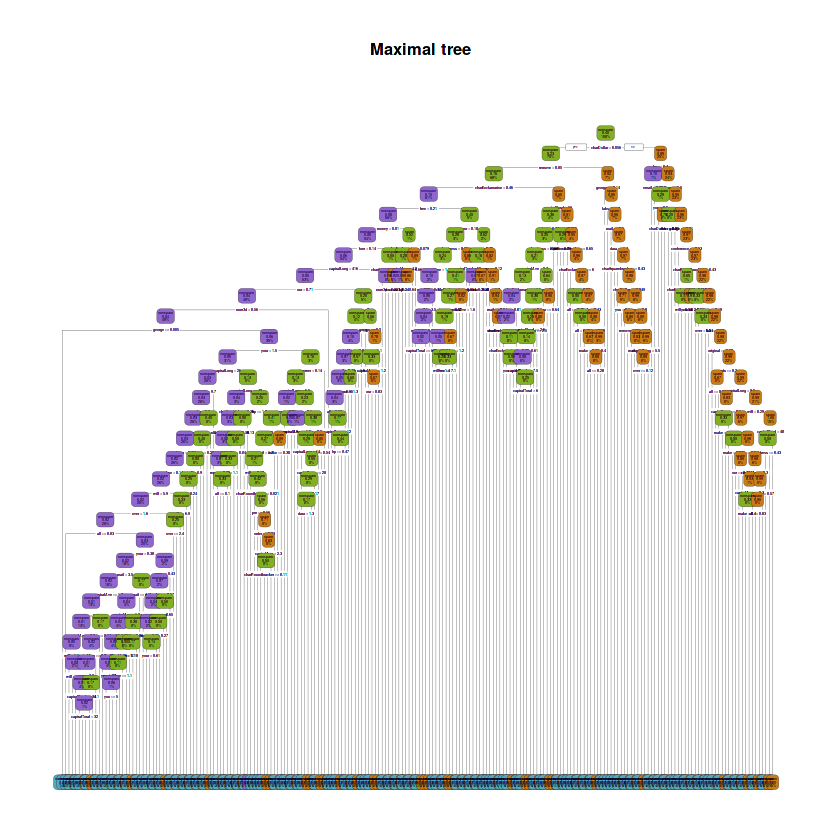

In [535]:
# Plot tree
rpart.plot(fit.train.max, main = "Maximal tree", 
           box.palette = rev(c(red, orange, green, purple, blue)), type = 2)

In [536]:
# Depth of tree
cat("The depth of the maximal tree is:", 
    max(rpart:::tree.depth(as.numeric(rownames(fit.train.max$frame)))), "\n")

# Number of leaves
cat("The number of leaves is:", 
    sum(fit.train.max$frame$var == "<leaf>"), "\n")

# Variables involved in splits
cat("The splits involved the following variables: \n")
purrr::map(unique(fit.train.max$frame$var[which(fit.train.max$frame$var != "<leaf>")]),
           ~ paste(as.character(.x)))

The depth of the maximal tree is: 29 
The number of leaves is: 212 
The splits involved the following variables: 


[[1]]
[1] "charDollar"

[[2]]
[1] "remove"

[[3]]
[1] "charExclamation"

[[4]]
[1] "free"

[[5]]
[1] "money"

[[6]]
[1] "font"

[[7]]
[1] "capitalLong"

[[8]]
[1] "our"

[[9]]
[1] "num3d"

[[10]]
[1] "george"

[[11]]
[1] "your"

[[12]]
[1] "credit"

[[13]]
[1] "make"

[[14]]
[1] "receive"

[[15]]
[1] "direct"

[[16]]
[1] "will"

[[17]]
[1] "over"

[[18]]
[1] "all"

[[19]]
[1] "mail"

[[20]]
[1] "capitalAve"

[[21]]
[1] "you"

[[22]]
[1] "capitalTotal"

[[23]]
[1] "re"

[[24]]
[1] "technology"

[[25]]
[1] "business"

[[26]]
[1] "address"

[[27]]
[1] "charSemicolon"

[[28]]
[1] "report"

[[29]]
[1] "hp"

[[30]]
[1] "num650"

[[31]]
[1] "email"

[[32]]
[1] "charRoundbracket"

[[33]]
[1] "pm"

[[34]]
[1] "order"

[[35]]
[1] "internet"

[[36]]
[1] "data"

[[37]]
[1] "num000"

[[38]]
[1] "edu"

[[39]]
[1] "original"

[[40]]
[1] "labs"

[[41]]
[1] "charSquarebracket"

[[42]]
[1] "conference"

[[43]]
[1] "hpl"

[[44]]
[1] "meeting"

[[45]]
[1] "lab"

[[46]]
[1] "num1999"

> The maximal tree has a depth of 29, it has 212 leaves and the splits involved 46 variables: *charDollar*, *remove*, *charExclamation*, *free*, *money*, *font*, *capitalLong*, *our*, *num3d*, *george*, *your*, *credit*, *make*, *receive*, *direct*, *will*, *over*, *all*, *mail*, *capitalAve*, *you*, *capitalTotal*, *re*, *technology*, *business*, *address*, *charSemicolon*, *report*, *hp*, *num650*, *email*, *charRoundbracket*, *pm*, *order*, *internet*, *data*, *num000*, *edu*, *original*, *labs*, *charSquarebracket*, *conference*, *hpl*, *meeting*, *lab* and *num1999*.

> The tree was constructed using some default `rpart` settings: following the Gini index of heterogeneity for growing the trees, 10 fold cross-validation pruning and `'class'` `method` since `type` (response variable) is categorical but unlimiting the spliting selecting a `cp` value of zero and `minsplitting` of 1.

### 2.6. Draw the cross-validation errors of the Breiman’s sequence of the pruned subtrees of the maximal tree and interpret it

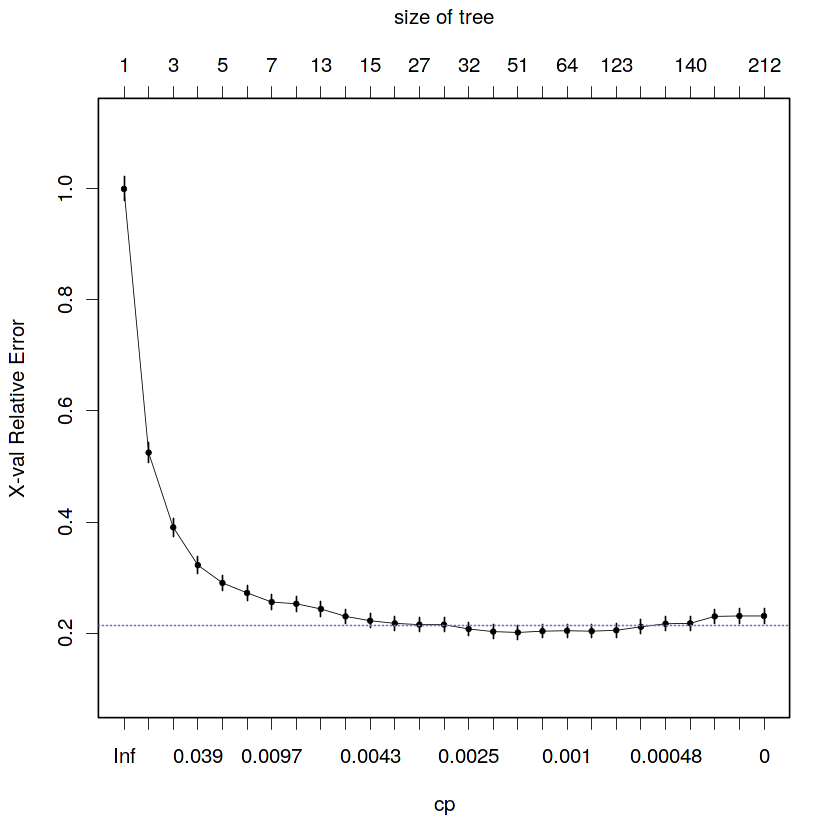

In [26]:
# Visual representation of the cross-validation prediction errors
plotcp(fit.train.max, minline = TRUE, lty = 3, col = purple, lwd = 0.5, pch = 19, cex = 0.5)

> The curve represents the average missclasification rate for each complexity parameter (*cp*) (or for each size of tree). Since 10 fold of cross-validation error and pruning were computed by `rpart` by default we have 10 missclasification rates at each *cp* value. So, we can compute both a mean and a standar deviation of the missclassification rate for each *cp* value. The line connects the means for each *cp* and the small vertical lines in each *cp* are one standar error (*1 SE*) above and below the mean. Also, the horizontal purple line highlights the minimum cross-validation prediction error plus *1 SE*.

> We can say that the average missclasification rate decrease with lower values of *cp* and higher tree size. However, the maximal tree overfits the data. So, the optimal tree is a pruned subtree of the maximal tree minimizing the prediction error penalized by the complexity of the model following some rule.

### 2.7. Find the best of them in the sense of an estimate given by the cross-validation prediction error

> After building the maximal tree (maybe large and/or complex), we have to decide how much of the model we want to retain. To do that, we can use the cross-validation prediction error rule to choose the best *cp* (minimum `xerror`).

- **Obtain the cp by calculating the minimum cross-validation error**

In [27]:
# Calculate best cp by cross-validation
min.cv.cell <- which.min(fit.train.max$cptable[, "xerror"])
fit.train.best.cv.cp <- fit.train.max$cptable[min.cv.cell, "CP"]
cat("The best critical parameter value given by the cross-validation prediction error is:", 
    fit.train.best.cv.cp)

The best critical parameter value given by the cross-validation prediction error is: 0.001173709

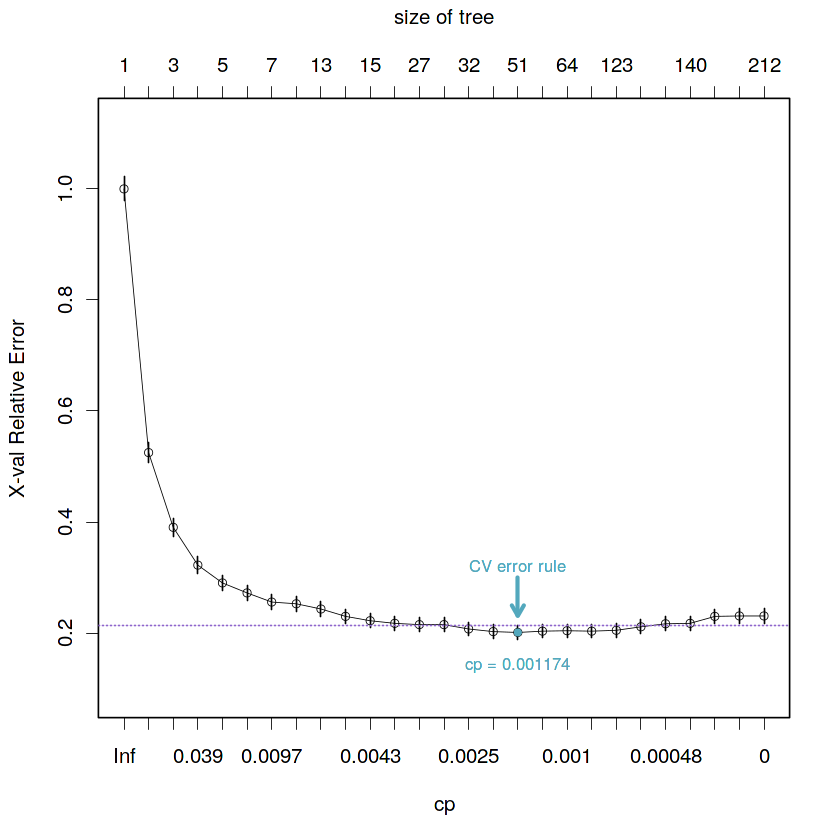

In [28]:
# Visual representation of the selected cross-validation prediction error
plotcp(fit.train.max, minline = TRUE, lty = 3, col = purple, lwd = 0.5, pch = 1, cex = 0.8)

# Plot selected point
points(x = min.cv.cell, 
       y = fit.train.max$cptable[which.min(fit.train.max$cptable[, "xerror"]), "xerror"],
       col = blue, pch = 19, cex = 0.6)

# Plot label with cp value
text(x = rep(min.cv.cell, 2), 
     y = fit.train.max$cptable[min.cv.cell, "xerror"] - 0.06,
     paste("cp =", round(fit.train.best.cv.cp, 6)), col = blue, cex = 0.8)

# Plot label with type of rule used
text(x = rep(min.cv.cell, 2),
     y = fit.train.max$cptable[min.cv.cell, "xerror"] + 0.12,
     "CV error rule", col = blue, cex = 0.8)

# Plot arrow indicating selected point position in plot
arrows(x0 = min.cv.cell,
       y0 = 0.3, 
       x1 = min.cv.cell, 
       y1 = fit.train.max$cptable[min.cv.cell, "xerror"] + 0.03, 
       angle = 30, col = blue, length = 0.1, lwd = 2.5, xpd = TRUE)

- **Obtain tree by applying the minimum cross-validation prediction error rule**

In [29]:
# Prune maximal tree using the best cp by cross-validation prediction error
fit.train.pruned.cv <- prune(fit.train.max, cp = fit.train.best.cv.cp)

Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”

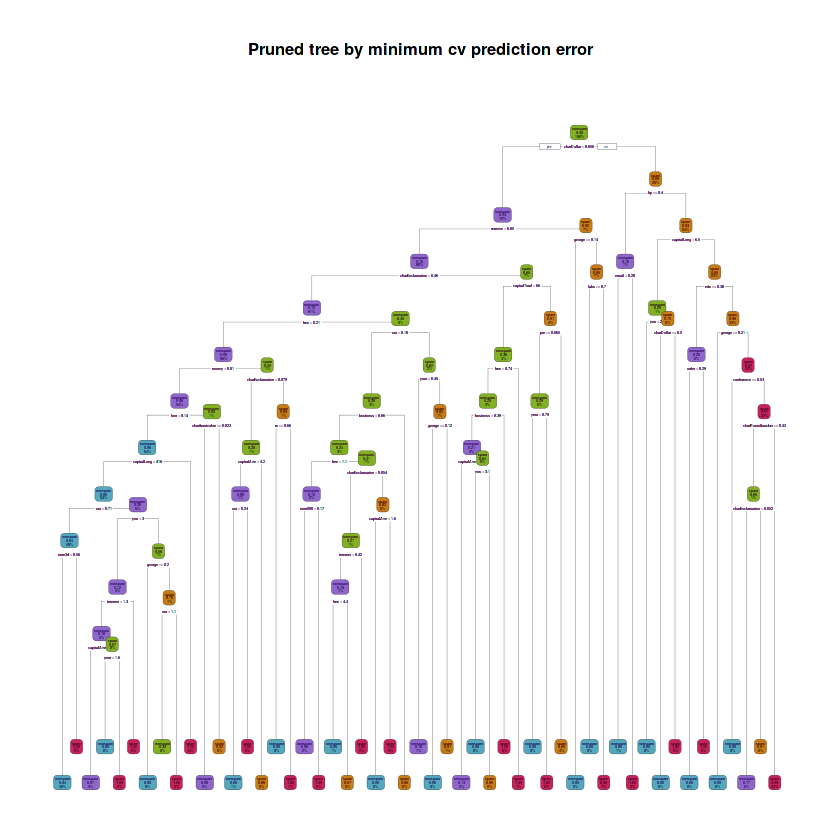

In [30]:
# Plot tree
rpart.plot(fit.train.pruned.cv, main = "Pruned tree by minimum cv prediction error", 
           box.palette = rev(c(red, orange, green, purple, blue)), type = 2)

In [31]:
# Depth of tree
cat("The depth of the pruned tree by minimum cv prediction error is:", max(rpart:::tree.depth(as.numeric(rownames(fit.train.pruned.cv$frame)))), "\n")

# Number of leaves
cat("The number of leaves is:", 
    sum(fit.train.pruned.cv$frame$var == "<leaf>"), "\n")

# Variables involved in splits
cat("The splits involved the following variables: \n")
purrr::map(unique(fit.train.pruned.cv$frame$var[which(fit.train.pruned.cv$frame$var != "<leaf>")]),
           ~ paste(as.character(.x)))

The depth of the pruned tree by minimum cv prediction error is: 12 
The number of leaves is: 51 
The splits involved the following variables: 


[[1]]
[1] "charDollar"

[[2]]
[1] "remove"

[[3]]
[1] "charExclamation"

[[4]]
[1] "free"

[[5]]
[1] "money"

[[6]]
[1] "font"

[[7]]
[1] "capitalLong"

[[8]]
[1] "our"

[[9]]
[1] "num3d"

[[10]]
[1] "you"

[[11]]
[1] "internet"

[[12]]
[1] "capitalAve"

[[13]]
[1] "your"

[[14]]
[1] "george"

[[15]]
[1] "charSemicolon"

[[16]]
[1] "re"

[[17]]
[1] "business"

[[18]]
[1] "num000"

[[19]]
[1] "capitalTotal"

[[20]]
[1] "pm"

[[21]]
[1] "labs"

[[22]]
[1] "hp"

[[23]]
[1] "email"

[[24]]
[1] "edu"

[[25]]
[1] "order"

[[26]]
[1] "conference"

[[27]]
[1] "charRoundbracket"

> The pruned tree using the best *cp* by selecting the minimum cross-validation prediction error approach has a depth of 12, it has 51 leaves and the splits involved 27 variables: *charDollar*, *remove*, *charExclamation*, *free*, *money*, *font*, *capitalLong*, *our*, *num3d*, *you*, *internet*, *capitalAve*, *your*, *george*, *charSemicolon*, *re*, *business*, *num000*, *capitalTotal*, *pm*, *labs*, *hp*, *email*, *edu*, *order*, *conference* and *charRoundbracket*.

### 2.8. Compare the default tree of rpart with the one obtained by minimizing the prediction error. Same question with the one obtained by applying the 1 SE rule

- **Obtain the cp by calculating the minimum cv error + 1 SE**

In [32]:
# Calculate the best cp by 1 SE rule: xerror < min(xerror) + xstd
# Sum the minimum cv prediction error and its 1 SE
xerr.plus.1se <- sum(fit.train.max$cptable[min.cv.cell, c("xerror", "xstd")])

# Select the cell which is closer to the sum of the minimum cv prediction error and its 1 SE
min.1se.cell <- which(fit.train.max$cptable[, c("xerror")] < xerr.plus.1se)[1]

# Select the CP value
fit.train.best.1se.cp <- fit.train.max$cptable[min.1se.cell, "CP"]
cat("The best critical parameter value given by the 1 SE rule is:", fit.train.best.1se.cp)

The best critical parameter value given by the 1 SE rule is: 0.002347418

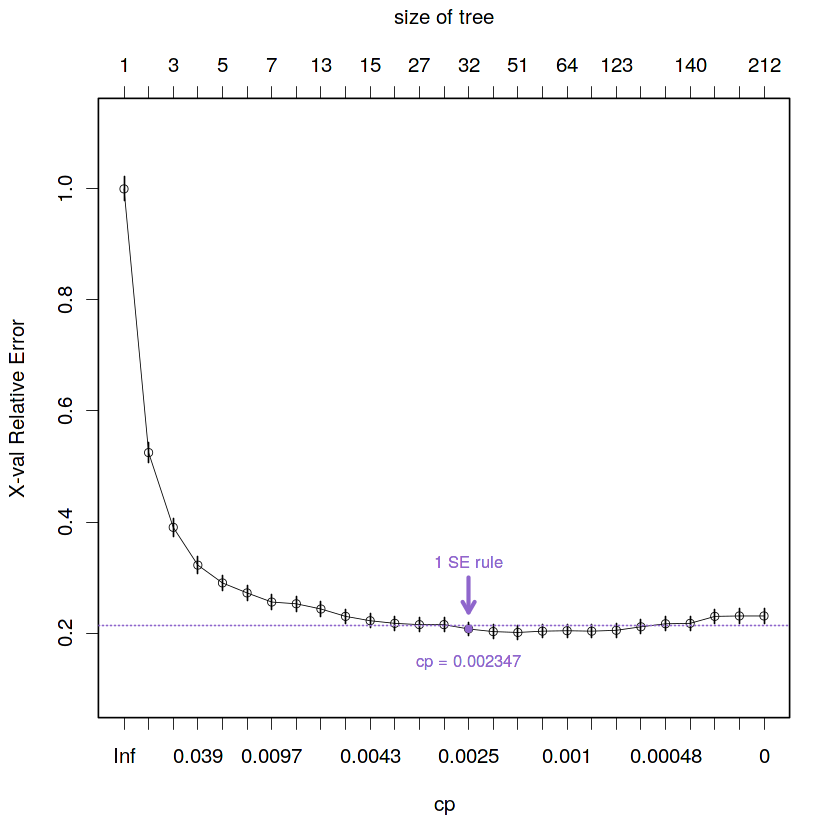

In [33]:
# Visual representation of the selected cp value by 1 SE rule
plotcp(fit.train.max, minline = TRUE, lty = 3, col = purple, lwd = 0.5, pch = 1, cex = 0.8)

# Plot selected point
points(x = min.1se.cell, 
       y = fit.train.max$cptable[min.1se.cell, "xerror"],
       col = purple, pch = 19, cex = 0.6)

# Plot label with cp value
text(x = rep(min.1se.cell, 2), 
     y = fit.train.max$cptable[min.1se.cell, "xerror"] - 0.06,
     paste("cp =", round(fit.train.best.1se.cp, 6)), col = purple, cex = 0.8)

# Plot label with type of rule used
text(x = rep(min.1se.cell, 2),
     y = fit.train.max$cptable[min.1se.cell, "xerror"] + 0.12,
     "1 SE rule", col = purple, cex = 0.8)

# Plot arrow indicating selected point position in plot
arrows(x0 = min.1se.cell,
       y0 = 0.3, 
       x1 = min.1se.cell, 
       y1 = fit.train.max$cptable[min.1se.cell, "xerror"] + 0.03, 
       angle = 30, col = purple, length = 0.1, lwd = 2.5, xpd = TRUE)

- **Obtain tree by applying the 1 SE rule**

In [34]:
# Prune maximal tree by 1 SE rule
fit.train.pruned.1se <- prune(fit.train.max, cp = fit.train.best.1se.cp)

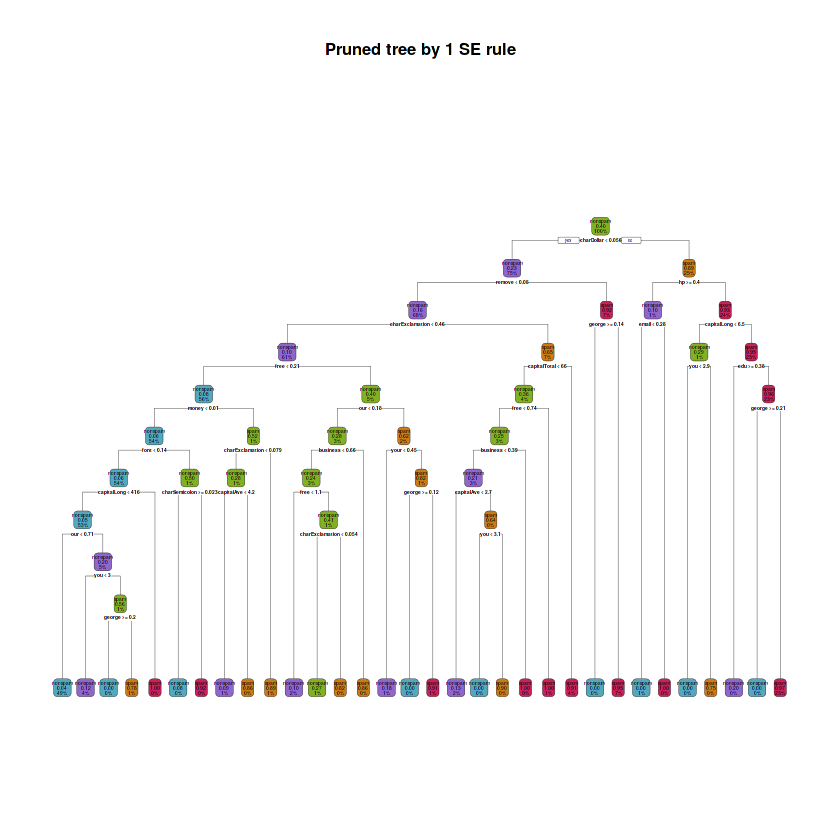

In [35]:
# Plot tree
rpart.plot(fit.train.pruned.1se, main = "Pruned tree by 1 SE rule", 
           box.palette = rev(c(red, orange, green, purple, blue)), type = 2)

In [537]:
# Depth of tree
cat("The depth of the pruned tree following the 1 SE rule is:", 
    max(rpart:::tree.depth(as.numeric(rownames(fit.train.pruned.1se$frame)))), "\n")

# Number of leaves
cat("The number of leaves is:", 
    sum(fit.train.pruned.1se$frame$var == "<leaf>"), "\n")

# Variables involved in splits
cat("The splits involved the following variables: \n")
purrr::map(unique(fit.train.pruned.1se$frame$var[which(fit.train.pruned.1se$frame$var != "<leaf>")]),
           ~ paste(as.character(.x)))

The depth of the pruned tree following the 1 SE rule is: 10 
The number of leaves is: 32 
The splits involved the following variables: 


[[1]]
[1] "charDollar"

[[2]]
[1] "remove"

[[3]]
[1] "charExclamation"

[[4]]
[1] "free"

[[5]]
[1] "money"

[[6]]
[1] "font"

[[7]]
[1] "capitalLong"

[[8]]
[1] "our"

[[9]]
[1] "you"

[[10]]
[1] "george"

[[11]]
[1] "charSemicolon"

[[12]]
[1] "capitalAve"

[[13]]
[1] "business"

[[14]]
[1] "your"

[[15]]
[1] "capitalTotal"

[[16]]
[1] "hp"

[[17]]
[1] "email"

[[18]]
[1] "edu"

> The pruned tree using the *cp* obtained by 1 SE rule has a depth of 10, it has 32 leaves and the splits involved 18 variables: *charDollar*, *remove*, *charExclamation*, *free*, *money*, *font*, *capitalLong*, *our*, *you*, *george*, *charSemicolon*, *capitalAve*, *business*, *your*, *capitalTotal*, *hp*, *email* and *edu*.

- **Summary of the diferent cp values by rule**

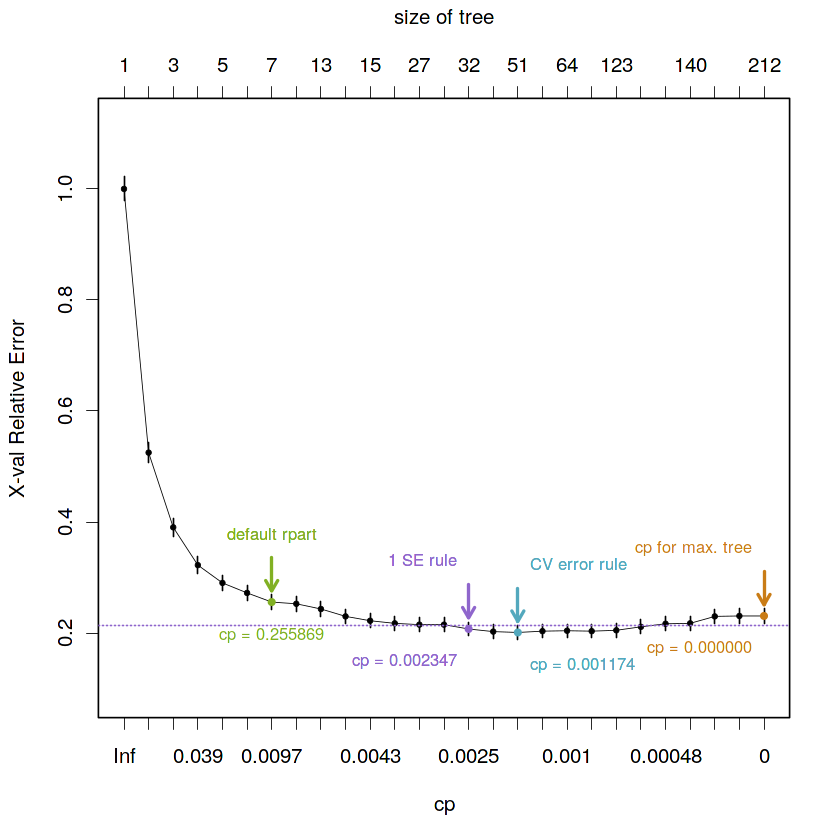

In [37]:
# Visual representation of the selected cp value by 1 SE rule
plotcp(fit.train.max, minline = TRUE, lty = 3, col = purple, lwd = 0.5, pch = 19, cex = 0.5)

# cp = 0, for maximal tree
points(x = which(fit.train.max$cptable[, c("CP")] == 0)[1], 
       y = fit.train.max$cptable[which(fit.train.max$cptable[, c("CP")] == 0)[1], "xerror"],
       col = orange, pch = 19, cex = 0.6)

text(x = which(fit.train.max$cptable[, c("CP")] == 0)[1], 
     y = fit.train.max$cptable[which(fit.train.max$cptable[, c("CP")] == 0)[1], "xerror"] - 0.06,
     paste("cp = 0.000000"), 
     col = orange, cex = 0.8, pos = 2)

text(x = which(fit.train.max$cptable[, c("CP")] == 0)[1],
     y = fit.train.max$cptable[which(fit.train.max$cptable[, c("CP")] == 0)[1], "xerror"] + 0.12,
     "cp for max. tree", col = orange, cex = 0.8, pos = 2)

arrows(x0 = which(fit.train.max$cptable[, c("CP")] == 0)[1], 
       y0 = fit.train.max$cptable[which(fit.train.max$cptable[, c("CP")] == 0)[1], "xerror"] + 0.08, 
       x1 = which(fit.train.max$cptable[, c("CP")] == 0)[1], 
       y1 = fit.train.max$cptable[which(fit.train.max$cptable[, c("CP")] == 0)[1], "xerror"] + 0.02, 
       angle = 30, col = orange, length = 0.1, lwd = 2, xpd = TRUE)

# cp = 0.01, default rpart value
points(x = which(fit.train.max$cptable[, c("CP")] < 0.01)[1], 
       y = fit.train.max$cptable[which(fit.train.max$cptable[, c("CP")] < 0.01)[1], "xerror"],
       col = green, pch = 19, cex = 0.6)

text(x = which(fit.train.max$cptable[, c("CP")] < 0.01)[1], 
     y = fit.train.max$cptable[which(fit.train.max$cptable[, c("CP")] < 0.01)[1], "xerror"] - 0.06,
     paste("cp =", round(fit.train.max$cptable[which(fit.train.max$cptable[, c("CP")] < 0.01)[1], "xerror"], 6)), 
     col = green, cex = 0.8)

text(x = rep(which(fit.train.max$cptable[, c("CP")] < 0.01)[1], 2),
     y = fit.train.max$cptable[which(fit.train.max$cptable[, c("CP")] < 0.01)[1], "xerror"] + 0.12,
     "default rpart", col = green, cex = 0.8)

arrows(x0 = which(fit.train.max$cptable[, c("CP")] < 0.01)[1], 
       y0 = fit.train.max$cptable[which(fit.train.max$cptable[, c("CP")] < 0.01)[1], "xerror"] + 0.08, 
       x1 = which(fit.train.max$cptable[, c("CP")] < 0.01)[1], 
       y1 = fit.train.max$cptable[which(fit.train.max$cptable[, c("CP")] < 0.01)[1], "xerror"] + 0.02, 
       angle = 30, col = green, length = 0.1, lwd = 2, xpd = TRUE)

# minimum cv prediction error rule
points(x = min.cv.cell, 
       y = fit.train.max$cptable[min.cv.cell, "xerror"],
       col = blue, pch = 19, cex = 0.6)

text(x = rep(min.cv.cell, 2), 
     y = fit.train.max$cptable[min.cv.cell, "xerror"] - 0.06,
     paste("cp =", round(fit.train.best.cv.cp, 6)), 
     col = blue, cex = 0.8, pos = 4)

text(x = rep(min.cv.cell, 2),
     y = fit.train.max$cptable[min.cv.cell, "xerror"] + 0.12,
     "CV error rule", col = blue, cex = 0.8, pos = 4)

arrows(x0 = min.cv.cell, y0 = fit.train.max$cptable[min.cv.cell, "xerror"] + 0.08, 
       x1 = min.cv.cell, y1 = fit.train.max$cptable[min.cv.cell, "xerror"] + 0.02, 
       angle = 30, col = blue, length = 0.1, lwd = 2, xpd = TRUE)

# 1 SE rule
points(x = min.1se.cell, 
       y = fit.train.max$cptable[min.1se.cell, "xerror"],
       col = purple, pch = 19, cex = 0.6)

text(x = rep(min.1se.cell, 2), 
     y = fit.train.max$cptable[min.1se.cell, "xerror"] - 0.06,
     paste("cp =", round(fit.train.best.1se.cp, 6)), 
     col = purple, cex = 0.8, pos = 2)

text(x = rep(min.1se.cell, 2),
     y = fit.train.max$cptable[min.1se.cell, "xerror"] + 0.12,
     "1 SE rule", col = purple, cex = 0.8, pos = 2)

arrows(x0 = min.1se.cell, y0 = fit.train.max$cptable[min.1se.cell, "xerror"] + 0.08, 
       x1 = min.1se.cell, y1 = fit.train.max$cptable[min.1se.cell, "xerror"] + 0.02, 
       angle = 30, col = purple, length = 0.1, lwd = 2, xpd = TRUE)

- **Compare trees: default rpart tree, pruned tree by best cv prediction error and pruned tree by 1 SE rule**

In [38]:
# Compare obtained trees
cat("Are default rpart tree identical to pruned tree by minimizing CV error rule? A:", 
    identical(fit.train.def, fit.train.pruned.cv), "\n")

cat("Are default rpart tree identical to pruned tree by 1 SE rule? A:", 
    identical(fit.train.def, fit.train.pruned.1se), "\n")

cat("Are pruned tree by by minimizing CV error rule identical to pruned tree by 1 SE rule? A:", 
    identical(fit.train.pruned.cv, fit.train.pruned.1se), "\n")

Are default rpart tree identical to pruned tree by minimizing CV error rule? A: FALSE 
Are default rpart tree identical to pruned tree by 1 SE rule? A: FALSE 
Are pruned tree by by minimizing CV error rule identical to pruned tree by 1 SE rule? A: FALSE 


> All the compared trees are different. They were build by different cp values hence different penalization frames. They have different depths, number of leaves, variables involved in splits and sizes.

### 2.9. Compare the errors of the different trees obtained, both in learning and in test

- **Missclasification error of default **rpart** tree**

In [39]:
# Apply fitted model tree to test dataset and calculate the gain and missclasification for each observation 
def.error <- test %>% mutate(pred = predict(fit.train.def, test, type = "class"),
                             gain = ifelse(pred == type, 1, 0),
                             error = ifelse(pred != type, 1, 0))

# Calculate the mean gain and mean missclasification and print them
(def.missc_error <- def.error %>% summarize(gain = mean(gain), missc_error = mean(error)))

gain,missc_error
0.8891304,0.1108696


- **Missclasification error of the stump tree (depth = 1)**

In [40]:
# Apply fitted model tree to test dataset and calculate the gain and missclasification for each observation 
d1.error <- test %>% mutate(pred = predict(fit.train.d1, test, type = "class"), 
                            gain = ifelse(pred == type, 1, 0),
                            error = ifelse(pred != type, 1, 0))

# Calculate the mean gain and mean missclasification and print them
(d1.missc_error <- d1.error %>% summarize(gain = mean(gain), missc_error = mean(error)))

gain,missc_error
0.7833333,0.2166667


- **Missclasification error of maximal tree**

In [41]:
# Apply fitted model tree to test dataset and calculate the gain and missclasification for each observation 
max.error <- test %>% mutate(pred = predict(fit.train.max, test, type = "class"),
                             gain = ifelse(pred == type, 1, 0),
                             error = ifelse(pred != type, 1, 0))

# Calculate the mean gain and mean missclasification and print them
(max.missc_error <- max.error %>% summarize(gain = mean(gain), missc_error = mean(error)))

gain,missc_error
0.9152174,0.08478261


- **Missclasification error of best CV tree model**

In [42]:
# Apply fitted model tree to test dataset and calculate the gain and missclasification for each observation 
cv.error <- test %>% mutate(pred = predict(fit.train.pruned.cv, test, type = "class"),
                            gain = ifelse(pred == type, 1, 0),
                            error = ifelse(pred != type, 1, 0))

# Calculate the mean gain and mean missclasification and print them
(cv.missc_error <- cv.error %>% summarize(gain = mean(gain), missc_error = mean(error)))

gain,missc_error
0.9253623,0.07463768


- **Missclasification error of 1 SE tree model**

In [43]:
# Apply fitted model tree to test dataset and calculate the gain and missclasification for each observation 
se.error <- test %>% mutate(pred = predict(fit.train.pruned.1se, test, type = "class"),
                            gain = ifelse(pred == type, 1, 0),
                            error = ifelse(pred != type, 1, 0))

# Calculate the mean gain and mean missclasification and print them
(se.missc_error <- se.error %>% summarize(gain = mean(gain), missc_error = mean(error)))

gain,missc_error
0.9173913,0.0826087


In [44]:
# Create dataframe with missclasification and gains of the tree models and sort by missclasification error
trees_missc <- rbind(def.missc_error, d1.missc_error, max.missc_error, cv.missc_error, se.missc_error) %>%  
                    mutate(model = c('tree_def', 'tree_d1', 'tree_max', 'tree_cv', 'tree_1se')) %>% 
                        arrange(missc_error) %>%
                            mutate(rank = 1:length(model)) %>%
                                select(rank, model, missc_error, gain)
trees_missc

rank,model,missc_error,gain
1,tree_cv,0.07463768,0.9253623
2,tree_1se,0.08260870,0.9173913
3,tree_max,0.08478261,0.9152174
4,tree_def,0.11086957,0.8891304
5,tree_d1,0.21666667,0.7833333


> The lowest missclasification (0.07463768) was for the pruned tree by selecting the minimum cross-validation prediction error (tree_cv).

## 3. Random Forests

### 3.1. Load the library randomForest

In [45]:
library(randomForest)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



### 3.2. Build a RF for mtry=p (unpruned bagging) and calculate the gain in terms of error with respect to a single tree

In [46]:
# Calculate p
p <- ncol(train) - 1

# Build a RF
(rf.bag <- randomForest(type ~ ., data = train, mtry = p))


Call:
 randomForest(formula = type ~ ., data = train, mtry = p) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 57

        OOB estimate of  error rate: 5.81%
Confusion matrix:
        nonspam spam class.error
nonspam    1867   76  0.03911477
spam        111 1167  0.08685446

#### Missclasification error from the Random Forest model

In [47]:
# Apply random forest fitted model to test dataset and calculate the gain 
# and missclasification for each observation 
rf.bag.error <- test %>% mutate(pred = predict(rf.bag, test, type = "class"),
                                gain = ifelse(pred == type, 1, 0),
                                error = ifelse(pred != type, 1, 0))

# Calculate the mean gain and mean missclasification and print them
(rf.bag.missc_error <- rf.bag.error %>% summarize(gain = mean(gain), 
                                                  missc_error = mean(error)))

gain,missc_error
0.9434783,0.05652174


- **Compare bag Random Forest model gain with the CART trees**

In [48]:
# Create dataframe with missclasification and gains of the tree models 
# and sort by missclasification error
rf_missc_comp1 <- rbind(rf.bag.missc_error) %>%  
                    mutate(model = c('rf_bag')) %>% 
                        select(model, missc_error, gain) 
                            
rf_missc_comp1 %>% 
    rbind(trees_missc[, 2:4]) %>% 
        arrange(missc_error) %>%
            mutate(rank = 1:length(model),
                   gain_increase = ifelse(is.na(gain[rank + 1]),
                                          yes = 0,
                                          no = gain - gain[rank + 1]), 
                  rel_gain_increase_percent = round(100 * gain_increase, 2)) %>% 
                select(rank, model, missc_error, gain, rel_gain_increase_percent)

rank,model,missc_error,gain,rel_gain_increase_percent
1,rf_bag,0.05652174,0.9434783,1.81
2,tree_cv,0.07463768,0.9253623,0.80
3,tree_1se,0.08260870,0.9173913,0.22
4,tree_max,0.08478261,0.9152174,2.61
5,tree_def,0.11086957,0.8891304,10.58
6,tree_d1,0.21666667,0.7833333,0.00


> When comparing between models, we can say that the bagging Random Forest model performs the best prediction among all the CART tree models used. Also, the bagging Random Forest model increase 1.81% more the overall gain than the best CART tree model (tree_cv).

### 3.3. Build a default RF

In [49]:
# Build a RF
(rf.def <- randomForest(type ~ ., data = train))


Call:
 randomForest(formula = type ~ ., data = train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 7

        OOB estimate of  error rate: 4.84%
Confusion matrix:
        nonspam spam class.error
nonspam    1879   64  0.03293875
spam         92 1186  0.07198748

### 3.4. Calculate an estimate of the prediction error and compare it to bagging

In [50]:
# Apply random forest fitted model to test dataset and calculate the gain 
# and missclasification for each observation 
rf.def.error <- test %>% mutate(pred = predict(rf.def, test, type = "class"),
                                gain = ifelse(pred == type, 1, 0),
                                error = ifelse(pred != type, 1, 0))

# Calculate the mean gain and mean missclasification and print them
(rf.def.missc_error <- rf.def.error %>% summarize(gain = mean(gain), 
                                                  missc_error = mean(error)))

gain,missc_error
0.9514493,0.04855072


- **Compare default and bagging Random Forest models gain**

In [51]:
# Create dataframe with missclasification and gains of the tree models 
# and sort by missclasification error
rf_missc_comp2 <- rbind(rf.def.missc_error) %>%
                    mutate(model = c('rf_def')) %>% 
                        select(model, missc_error, gain)                        

rf_missc_comp2 <- 
        rf_missc_comp2 %>%
            rbind(rf_missc_comp1) %>% 
                #rbind(trees_missc[, 2:4]) %>%
                    arrange(missc_error) %>%
                        mutate(rank = 1:length(model),
                               gain_increase = ifelse(is.na(gain[rank + 1]),
                                                yes = 0,
                                                no = gain - gain[rank + 1]),
                                rel_gain_increase_percent = round(100 * gain_increase, 2)) %>% 
                                    select(rank, model, missc_error, gain, rel_gain_increase_percent)
# Print results
rf_missc_comp2

rank,model,missc_error,gain,rel_gain_increase_percent
1,rf_def,0.04855072,0.9514493,0.8
2,rf_bag,0.05652174,0.9434783,0.0


> When comparing between models, we can say that the default Random Forest model performs the best prediction. Also, the default Random Forest model increase 0.80% more the overall gain than the bagging Random Forest model.

### 3.5. Study the evolution of the OOB error with respect to ntree using do.trace

In [52]:
# Build a RF with do trace
rf.def.trace <- randomForest(type ~ ., data = train,  ntree = 1000, do.trace = 100)

ntree      OOB      1      2
  100:   5.34%  3.50%  8.14%
  200:   5.06%  3.29%  7.75%
  300:   5.18%  3.24%  8.14%
  400:   4.87%  3.19%  7.43%
  500:   4.81%  3.14%  7.36%
  600:   4.97%  3.19%  7.67%
  700:   4.91%  3.14%  7.59%
  800:   4.91%  3.04%  7.75%
  900:   4.91%  3.09%  7.67%
 1000:   4.94%  3.04%  7.82%


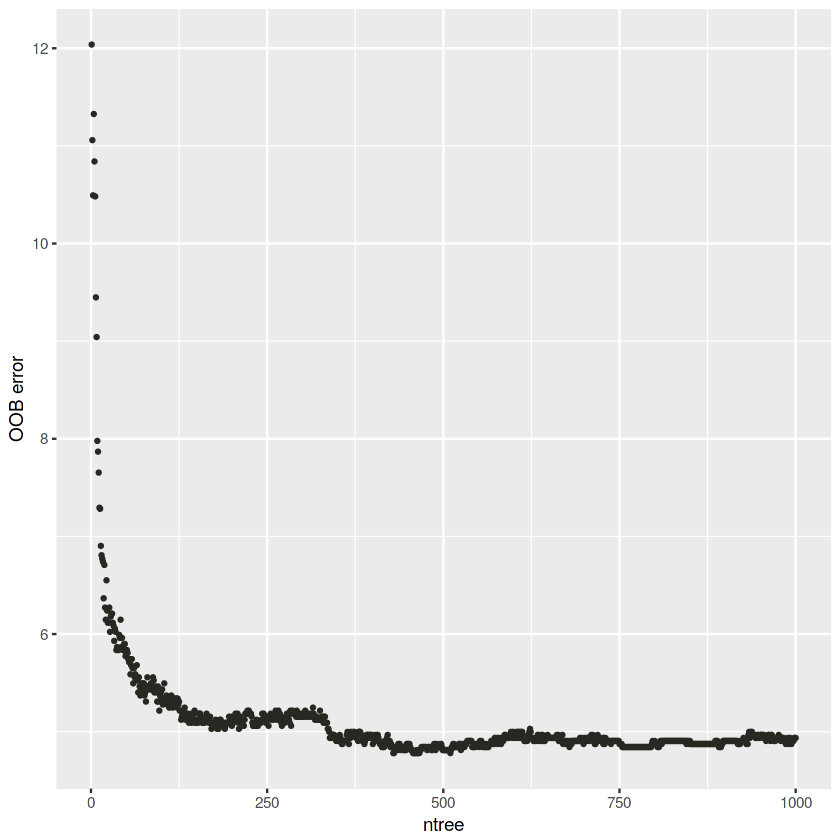

In [53]:
# Create dataframe
rf.def.trace.oob <- as.data.frame(rf.def.trace$err.rate)
rf.def.trace.oob$OOB <- rf.def.trace.oob$OOB * 100

# Plot OOB vs ntree
ggplot(rf.def.trace.oob, aes(x = 1:length(OOB), y = OOB)) + 
geom_point(cex = 0.75, color = darkgray, show.legend = FALSE) + 
labs(x = "ntree", y = "OOB error")

> The OOB error decrease with the number of trees. 

## 4. Variable importance

### 4.1. Calculate the variable importance of the spam variables for the default RF

In [54]:
# Build a RF
rf.def <- randomForest(type ~ ., data = train, ntree = 1000, importance = TRUE)

In [55]:
# Get importance
imp.def <- as.data.frame(rf.def$importance)
imp.def$variable <- rownames(imp.def)

# Print the top 10 most important variables
imp.def <- imp.def %>% 
               arrange(desc(MeanDecreaseAccuracy)) %>%
                   mutate(rank = 1:length(MeanDecreaseAccuracy), 
                          percent = round(100 * MeanDecreaseAccuracy / sum(MeanDecreaseAccuracy), 2)) %>% 
                       select(rank, variable, MeanDecreaseAccuracy, percent) 

imp.def %>% top_n(10, MeanDecreaseAccuracy)

rank,variable,MeanDecreaseAccuracy,percent
1,capitalLong,0.04627599,9.78
2,charExclamation,0.04001535,8.46
3,hp,0.03611121,7.63
4,remove,0.03600548,7.61
5,charDollar,0.03345314,7.07
6,capitalTotal,0.03181194,6.72
7,capitalAve,0.03089418,6.53
8,free,0.02378515,5.03
9,george,0.02110595,4.46
10,your,0.01945892,4.11


### 4.2. What are the most important variables?

> **Answer:** the most important variables are *capitalLong*, *charExclamation*, *remove*, *hp*, *charDollar*, *capitalTotal* and *capitalAve* (Mean Decrease Accuracy > 0.03).

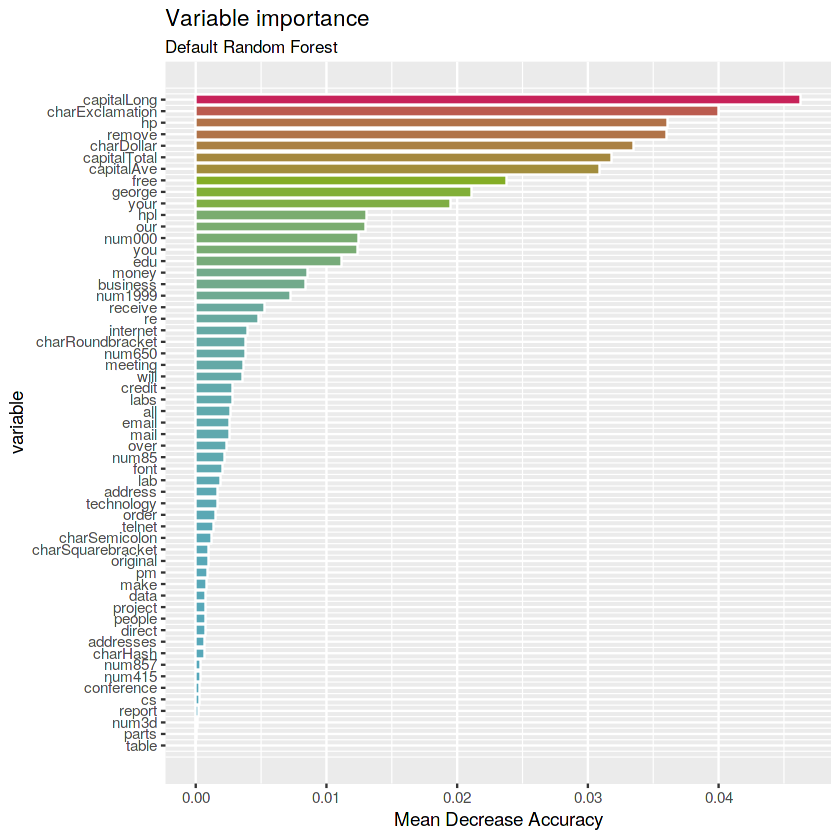

In [56]:
# Plot the variables by importance 
ggplot(imp.def) +
geom_col(aes(x = -rank, y = MeanDecreaseAccuracy, 
             fill = MeanDecreaseAccuracy), 
         color = "white", show.legend = FALSE) + 
labs(x = "variable", y = "Mean Decrease Accuracy", 
     title = "Variable importance", 
     subtitle = "Default Random Forest") + 
scale_x_continuous(labels = imp.def$variable, breaks = -imp.def$rank) +
scale_fill_gradientn(colours = c(blue, green, red)) + 
coord_flip()

### 4.3. Calculate the importance of spam variables for stumps RF

- ** Bagging stump RF**

In [57]:
(rf.bagstump <- randomForest(type ~ ., data = train, maxnodes = 2, 
                             mtry = p, ntree = 1000, importance = TRUE))


Call:
 randomForest(formula = type ~ ., data = train, maxnodes = 2,      mtry = p, ntree = 1000, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 57

        OOB estimate of  error rate: 19.84%
Confusion matrix:
        nonspam spam class.error
nonspam    1851   92  0.04734946
spam        547  731  0.42801252

In [58]:
# Get importance
imp.bagstump <- as.data.frame(rf.bagstump$importance)
imp.bagstump$variable <- rownames(imp.bagstump)

# Print the top 10 most important variables
imp.bagstump <- imp.bagstump %>%
                    arrange(desc(MeanDecreaseAccuracy)) %>%
                        mutate(rank = 1:length(MeanDecreaseAccuracy),
                               percent = round(100 * MeanDecreaseAccuracy / sum(MeanDecreaseAccuracy), 2)) %>% 
                            select(rank, variable, MeanDecreaseAccuracy, percent) 

imp.bagstump[1:10,]

rank,variable,MeanDecreaseAccuracy,percent
1,charDollar,0.1416649,55.51
2,charExclamation,0.1135189,44.49
3,make,0.0000000,0.00
4,address,0.0000000,0.00
5,all,0.0000000,0.00
6,num3d,0.0000000,0.00
7,our,0.0000000,0.00
8,over,0.0000000,0.00
9,remove,0.0000000,0.00
10,internet,0.0000000,0.00


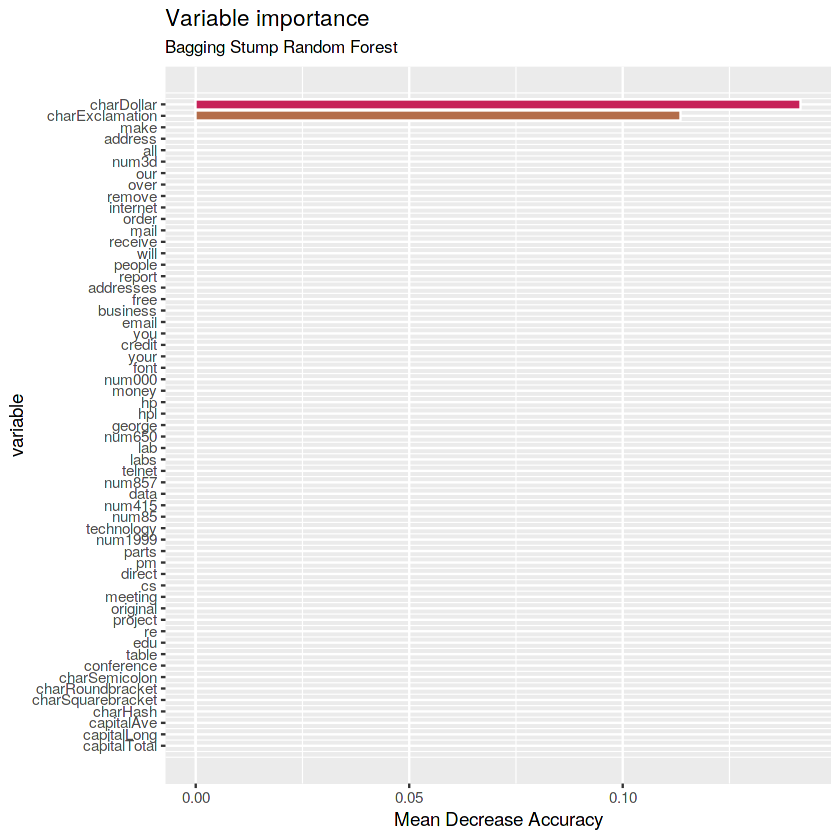

In [59]:
# Plot the variables by importance 
ggplot(imp.bagstump) +
geom_col(aes(x = -rank, y = MeanDecreaseAccuracy, 
             fill = MeanDecreaseAccuracy), 
         color = "white", show.legend = FALSE) + 
labs(x = "variable", y = "Mean Decrease Accuracy", 
     title = "Variable importance", 
     subtitle = "Bagging Stump Random Forest") + 
scale_x_continuous(labels = imp.bagstump$variable, breaks = -imp.bagstump$rank) +
scale_fill_gradientn(colours = c(blue, green, red)) + 
coord_flip()

> **Answer:** the most important variables for Bagging Stump Random Forest are *charDollar* and *charExclamation*.

- ** Default mtry stump RF**

In [60]:
(rf.defstump <- randomForest(type ~ ., data = train, maxnodes = 2, 
                             ntree = 1000, importance = TRUE))


Call:
 randomForest(formula = type ~ ., data = train, maxnodes = 2,      ntree = 1000, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 7

        OOB estimate of  error rate: 16.24%
Confusion matrix:
        nonspam spam class.error
nonspam    1920   23  0.01183736
spam        500  778  0.39123631

In [61]:
# Get importance
imp.defstump <- as.data.frame(rf.defstump$importance)
imp.defstump$variable <- rownames(imp.defstump)

# Print the top 10 most important variables
imp.defstump <- imp.defstump %>%
                    arrange(desc(MeanDecreaseAccuracy)) %>%
                        mutate(rank = 1:length(MeanDecreaseAccuracy),
                               percent = round(100 * MeanDecreaseAccuracy / sum(MeanDecreaseAccuracy), 2)) %>% 
                            select(rank, variable, MeanDecreaseAccuracy, percent) 

imp.defstump %>% top_n(10, MeanDecreaseAccuracy)

rank,variable,MeanDecreaseAccuracy,percent
1,charDollar,0.029005864,15.06
2,charExclamation,0.027390307,14.22
3,your,0.024795465,12.88
4,remove,0.015878207,8.25
5,free,0.015630594,8.12
6,capitalLong,0.014367496,7.46
7,money,0.010460490,5.43
8,capitalAve,0.010300224,5.35
9,our,0.008712112,4.52
10,num000,0.007174481,3.73


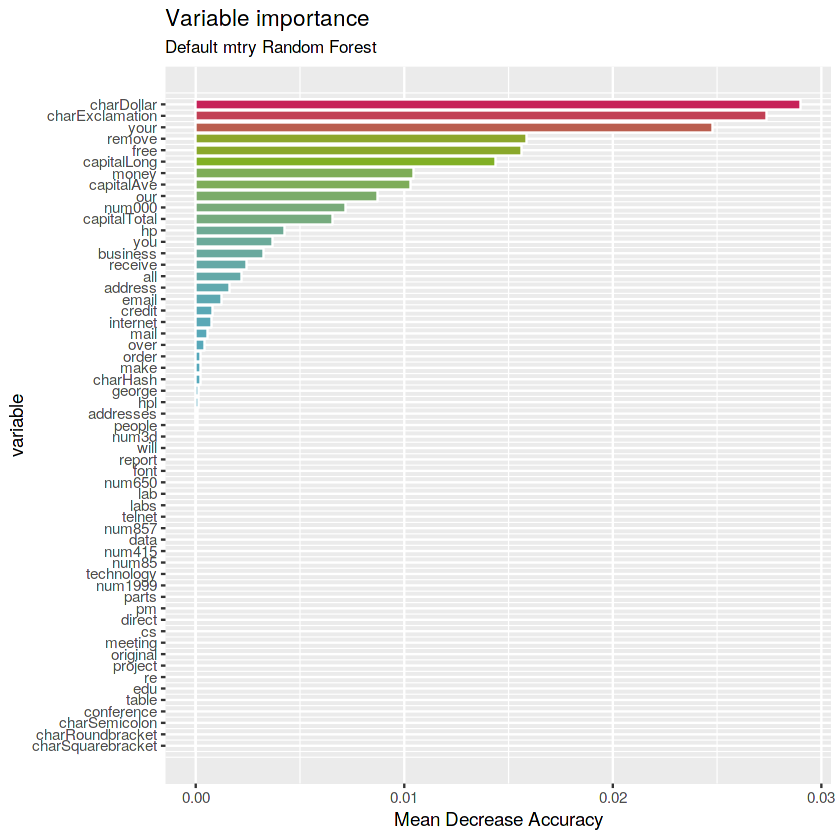

In [62]:
# Plot the variables by importance 
ggplot(imp.defstump) +
geom_col(aes(x = -rank, y = MeanDecreaseAccuracy, fill = MeanDecreaseAccuracy), color = "white", show.legend = FALSE) + 
labs(x = "variable", y = "Mean Decrease Accuracy", title = "Variable importance", subtitle = "Default mtry Random Forest") + 
scale_x_continuous(labels = imp.defstump$variable, breaks = -imp.defstump$rank) +
scale_fill_gradientn(colours = c(blue, green, red)) + 
coord_flip()

> **Answer:** the most important variables for Default `mtry` Random Forest are *charDollar*, *charExclamation* and *your*.

- ** mtry 1 stump RF**

In [63]:
(rf.1stump <- randomForest(type ~ ., data = train, maxnodes = 2, 
                           mtry = 1, ntree = 1000, importance = TRUE))


Call:
 randomForest(formula = type ~ ., data = train, maxnodes = 2,      mtry = 1, ntree = 1000, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 1

        OOB estimate of  error rate: 39.65%
Confusion matrix:
        nonspam spam class.error
nonspam    1943    0   0.0000000
spam       1277    1   0.9992175

In [541]:
# Get importance
imp.1stump <- as.data.frame(rf.1stump$importance)
imp.1stump$variable <- rownames(imp.1stump)

# Print the top 10 most important variables
imp.1stump <- imp.1stump %>%
                    arrange(desc(MeanDecreaseAccuracy)) %>%
                        mutate(rank = 1:length(MeanDecreaseAccuracy),
                               percent = round(100 * MeanDecreaseAccuracy / sum(MeanDecreaseAccuracy), 2)) %>% 
                            select(rank, variable, MeanDecreaseAccuracy, percent) 

imp.1stump %>% top_n(10, MeanDecreaseAccuracy)

rank,variable,MeanDecreaseAccuracy,percent
1,charExclamation,0.006512100,8.80
2,remove,0.004287234,5.79
3,num000,0.004111496,5.55
4,our,0.004010923,5.42
5,your,0.003899466,5.27
6,capitalLong,0.003638356,4.91
7,money,0.003598467,4.86
8,you,0.003576326,4.83
9,over,0.003220236,4.35
10,charDollar,0.003198435,4.32


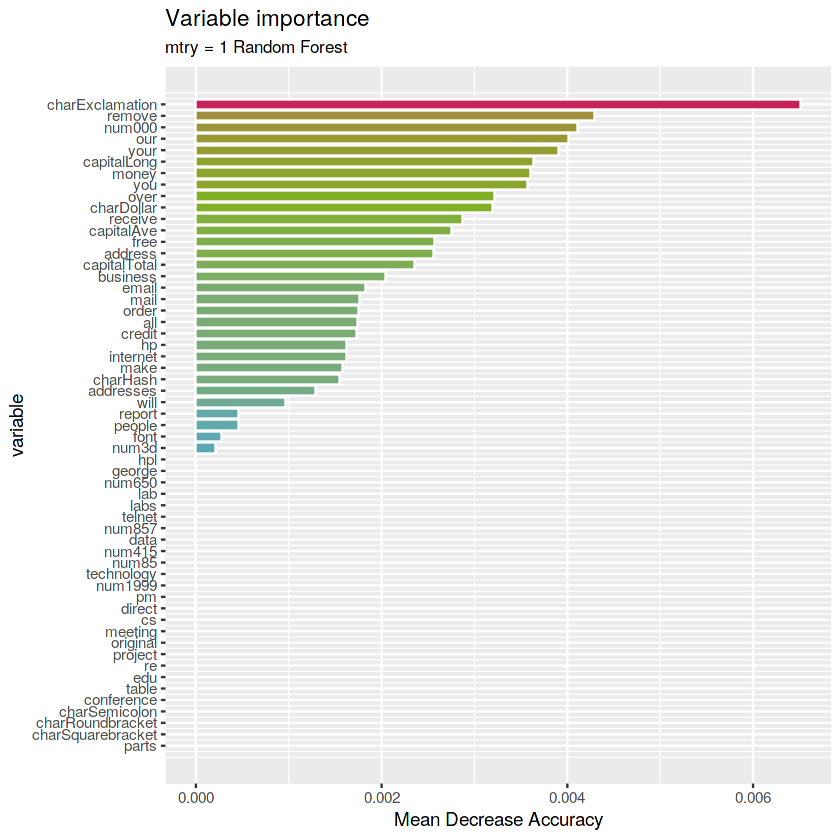

In [65]:
# Plot the variables by importance 
ggplot(imp.1stump) +
geom_col(aes(x = -rank, y = MeanDecreaseAccuracy, 
             fill = MeanDecreaseAccuracy), 
         color = "white", show.legend = FALSE) + 
labs(x = "variable", y = "Mean Decrease Accuracy", 
     title = "Variable importance", 
     subtitle = "mtry = 1 Random Forest") + 
scale_x_continuous(labels = imp.1stump$variable, breaks = -imp.1stump$rank) +
scale_fill_gradientn(colours = c(blue, green, red)) + 
coord_flip()

> **Answer:** the most important variables for `mtry=1` Random Forest is *charExclamation*.

- **Compare the prediction performance of all the models**

In [66]:
# Apply random forest fitted model to test dataset and 
# calculate the gain and missclasification for each observation 
rf.bagstump.error <- test %>% mutate(pred = predict(rf.bagstump, test, type = "class"),
                                     gain = ifelse(pred == type, 1, 0),
                                     error = ifelse(pred != type, 1, 0))

rf.defstump.error <- test %>% mutate(pred = predict(rf.defstump, test, type = "class"),
                                     gain = ifelse(pred == type, 1, 0),
                                     error = ifelse(pred != type, 1, 0))

rf.1stump.error <- test %>% mutate(pred = predict(rf.1stump, test, type = "class"),
                                   gain = ifelse(pred == type, 1, 0),
                                   error = ifelse(pred != type, 1, 0))

# Calculate the mean gain and mean missclasification and print them
rf.bagstump.missc_error <- rf.bagstump.error %>% summarize(gain = mean(gain), missc_error = mean(error))
rf.defstump.missc_error <- rf.defstump.error %>% summarize(gain = mean(gain), missc_error = mean(error))
rf.1stump.missc_error <- rf.1stump.error %>% summarize(gain = mean(gain), missc_error = mean(error))

In [67]:
# Create dataframe with missclasification and gains of the tree models 
# and sort by missclasification error
rf_missc_comp3 <- rbind(rf.bagstump.missc_error, rf.defstump.missc_error, rf.1stump.missc_error) %>% 
                    mutate(model = c('rf_bagstump', 'rf_defstump', 'rf_1stump')) %>% 
                        select(model, missc_error, gain)   
rf_missc_comp3 <- 
        rf_missc_comp3 %>%
            rbind(rf_missc_comp2[, 2:4]) %>% 
                rbind(trees_missc[, 2:4]) %>%
                    arrange(missc_error) %>%
                        mutate(rank = 1:length(model),
                               gain_increase = ifelse(is.na(gain[rank + 1]),
                                                yes = 0,
                                                no = gain - gain[rank + 1]),
                                rel_gain_increase_percent = round(100 * gain_increase, 2)) %>% 
                                    select(rank, model, missc_error, gain, rel_gain_increase_percent)

rf_missc_comp3

rank,model,missc_error,gain,rel_gain_increase_percent
1,rf_def,0.04855072,0.9514493,0.80
2,rf_bag,0.05652174,0.9434783,1.81
3,tree_cv,0.07463768,0.9253623,0.80
4,tree_1se,0.08260870,0.9173913,0.22
5,tree_max,0.08478261,0.9152174,2.61
6,tree_def,0.11086957,0.8891304,5.29
7,rf_defstump,0.16376812,0.8362319,4.78
8,rf_bagstump,0.21159420,0.7884058,0.51
9,tree_d1,0.21666667,0.7833333,17.10
10,rf_1stump,0.38768116,0.6123188,0.00


> The best prediction is done by the default Random Forest model.

### 4.4. Illustrate the influence of the mtry parameter on the OOB error and on the VI

- **Calculate RF for different `mtry` values as a fraction of *p***

In [68]:
rf.p1 <- randomForest(type ~ ., data = train, mtry = p, ntree = 1000, importance = TRUE)
rf.p2 <- randomForest(type ~ ., data = train, mtry = p/2, ntree = 1000, importance = TRUE)
rf.p3 <- randomForest(type ~ ., data = train, mtry = p/3, ntree = 1000, importance = TRUE)
rf.p4 <- randomForest(type ~ ., data = train, mtry = p/4, ntree = 1000, importance = TRUE)
rf.p5 <- randomForest(type ~ ., data = train, mtry = p/5, ntree = 1000, importance = TRUE)
rf.p6 <- randomForest(type ~ ., data = train, mtry = p/6, ntree = 1000, importance = TRUE)
rf.p7 <- randomForest(type ~ ., data = train, mtry = p/7, ntree = 1000, importance = TRUE)
rf.p8 <- randomForest(type ~ ., data = train, mtry = p/8, ntree = 1000, importance = TRUE)
rf.p9 <- randomForest(type ~ ., data = train, mtry = p/9, ntree = 1000, importance = TRUE)
rf.p10 <- randomForest(type ~ ., data = train, mtry = p/10, ntree = 1000, importance = TRUE)

- **Get OOB error for each tree**

In [69]:
# Create oob error dataframe
rf.p1.oob <- data.frame(rf.p1$err.rate) %>% select(OOB) %>% mutate(OOB = OOB * 100, ntree = 1:length(OOB), mtry = "p")
rf.p2.oob <- data.frame(rf.p2$err.rate) %>% select(OOB) %>% mutate(OOB = OOB * 100, ntree = 1:length(OOB), mtry = "p/2")
rf.p3.oob <- data.frame(rf.p3$err.rate) %>% select(OOB) %>% mutate(OOB = OOB * 100, ntree = 1:length(OOB), mtry = "p/3")
rf.p4.oob <- data.frame(rf.p4$err.rate) %>% select(OOB) %>% mutate(OOB = OOB * 100, ntree = 1:length(OOB), mtry = "p/4")
rf.p5.oob <- data.frame(rf.p5$err.rate) %>% select(OOB) %>% mutate(OOB = OOB * 100, ntree = 1:length(OOB), mtry = "p/5")
rf.p6.oob <- data.frame(rf.p6$err.rate) %>% select(OOB) %>% mutate(OOB = OOB * 100, ntree = 1:length(OOB), mtry = "p/6")
rf.p7.oob <- data.frame(rf.p7$err.rate) %>% select(OOB) %>% mutate(OOB = OOB * 100, ntree = 1:length(OOB), mtry = "p/7")
rf.p8.oob <- data.frame(rf.p8$err.rate) %>% select(OOB) %>% mutate(OOB = OOB * 100, ntree = 1:length(OOB), mtry = "p/8")
rf.p9.oob <- data.frame(rf.p9$err.rate) %>% select(OOB) %>% mutate(OOB = OOB * 100, ntree = 1:length(OOB), mtry = "p/9")
rf.p10.oob <- data.frame(rf.p10$err.rate) %>% select(OOB) %>% mutate(OOB = OOB * 100, ntree = 1:length(OOB), mtry = "p/10")

# Bind 
rf.p.oob <- rbind(rf.p1.oob, rf.p2.oob, rf.p3.oob, rf.p4.oob, rf.p5.oob, rf.p6.oob, rf.p7.oob, rf.p8.oob, rf.p9.oob, rf.p10.oob)

- **Plot mtry vs OOB error**

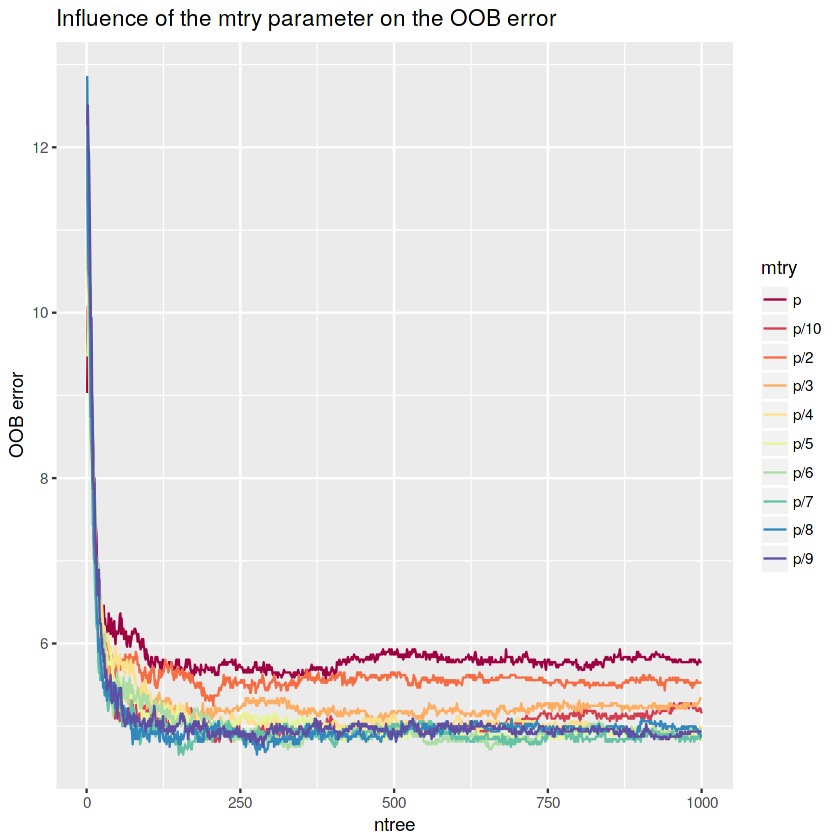

In [70]:
# Plot OOB error vs ntree
ggplot() + 
geom_line(data = rf.p.oob, aes(x = ntree, y = OOB, color = mtry), lwd = 0.5, show.legend = TRUE) + 
labs(x = "ntree", y = "OOB error", title = "Influence of the mtry parameter on the OOB error") +
scale_color_brewer(palette = "Spectral")

> The OOB error tends to decrease with lower `mtry` values. However, the OOB error seems to have the lowest values with p/7 and p/8 (`mtry ~ 8` and `mtry ~ 7`).

- **Get Variable importance for each RF model**

In [71]:
# Get importance by RF model
imp.rf.p1 <- as.data.frame(rf.p1$importance) %>% 
                mutate(variable = rownames(as.data.frame(rf.p1$importance)), model = "p") %>% 
                    select(variable, MeanDecreaseAccuracy, model)

imp.rf.p2 <- as.data.frame(rf.p2$importance) %>% 
                mutate(variable = rownames(as.data.frame(rf.p2$importance)), model = "p/2") %>% 
                    select(variable, MeanDecreaseAccuracy, model)

imp.rf.p3 <- as.data.frame(rf.p3$importance) %>% 
                mutate(variable = rownames(as.data.frame(rf.p3$importance)), model = "p/3") %>% 
                    select(variable, MeanDecreaseAccuracy, model)

imp.rf.p4 <- as.data.frame(rf.p4$importance) %>% 
                mutate(variable = rownames(as.data.frame(rf.p4$importance)), model = "p/4") %>% 
                    select(variable, MeanDecreaseAccuracy, model)

imp.rf.p5 <- as.data.frame(rf.p5$importance) %>% 
                mutate(variable = rownames(as.data.frame(rf.p5$importance)), model = "p/5") %>% 
                    select(variable, MeanDecreaseAccuracy, model)

imp.rf.p6 <- as.data.frame(rf.p6$importance) %>% 
                mutate(variable = rownames(as.data.frame(rf.p6$importance)), model = "p/6") %>% 
                    select(variable, MeanDecreaseAccuracy, model)

imp.rf.p7 <- as.data.frame(rf.p7$importance) %>% 
                mutate(variable = rownames(as.data.frame(rf.p7$importance)), model = "p/7") %>% 
                    select(variable, MeanDecreaseAccuracy, model)

imp.rf.p8 <- as.data.frame(rf.p8$importance) %>% 
                mutate(variable = rownames(as.data.frame(rf.p8$importance)), model = "p/8") %>% 
                    select(variable, MeanDecreaseAccuracy, model)

imp.rf.p9 <- as.data.frame(rf.p9$importance) %>% 
                mutate(variable = rownames(as.data.frame(rf.p9$importance)), model = "p/9") %>% 
                    select(variable, MeanDecreaseAccuracy, model)

imp.rf.p10 <- as.data.frame(rf.p10$importance) %>% 
                mutate(variable = rownames(as.data.frame(rf.p10$importance)), model = "p/10") %>% 
                    select(variable, MeanDecreaseAccuracy, model)

In [72]:
# Create matrix of p rows and 10 columns (p, p/2, ..., p/10)
varimp.matrix <- cbind(imp.rf.p1$MeanDecreaseAccuracy,
                       imp.rf.p2$MeanDecreaseAccuracy,
                       imp.rf.p3$MeanDecreaseAccuracy,
                       imp.rf.p4$MeanDecreaseAccuracy,
                       imp.rf.p5$MeanDecreaseAccuracy,
                       imp.rf.p6$MeanDecreaseAccuracy,
                       imp.rf.p7$MeanDecreaseAccuracy,
                       imp.rf.p8$MeanDecreaseAccuracy,
                       imp.rf.p9$MeanDecreaseAccuracy,
                       imp.rf.p10$MeanDecreaseAccuracy)

varimp.matrix <- as.matrix(varimp.matrix)

# Add rownames 
rownames(varimp.matrix) <- imp.rf.p1$variable
colnames(varimp.matrix) <- c("p", "p/2", "p/3", "p/4", "p/5", "p/6", "p/7", "p/8", "p/9", "p/10")

# Print matrix
head(varimp.matrix)

,p,p/2,p/3,p/4,p/5,p/6,p/7,p/8,p/9,p/10
make,0.0005855910,0.0004838696,0.0005251993,0.0005915873,0.0005934047,0.0006129338,0.0007381711,0.0009062411,0.0009668449,0.0010958450
address,0.0007265287,0.0007252229,0.0007985105,0.0007838046,0.0011288075,0.0011668933,0.0014152413,0.0016677993,0.0020061580,0.0020215021
all,0.0004947699,0.0009494042,0.0012698607,0.0015970114,0.0018728020,0.0019710361,0.0023535641,0.0025835082,0.0028964169,0.0029171954
num3d,0.0008152819,0.0004904992,0.0003899677,0.0002538936,0.0002165847,0.0001958520,0.0001819978,0.0001664966,0.0001658828,0.0001985471
our,0.0096749688,0.0104389426,0.0112271158,0.0120040579,0.0120222919,0.0124558002,0.0129556856,0.0130582495,0.0128052244,0.0134279955
over,0.0027184494,0.0023165785,0.0022766016,0.0020527525,0.0019944168,0.0020819442,0.0022617900,0.0023399286,0.0024194732,0.0024655542


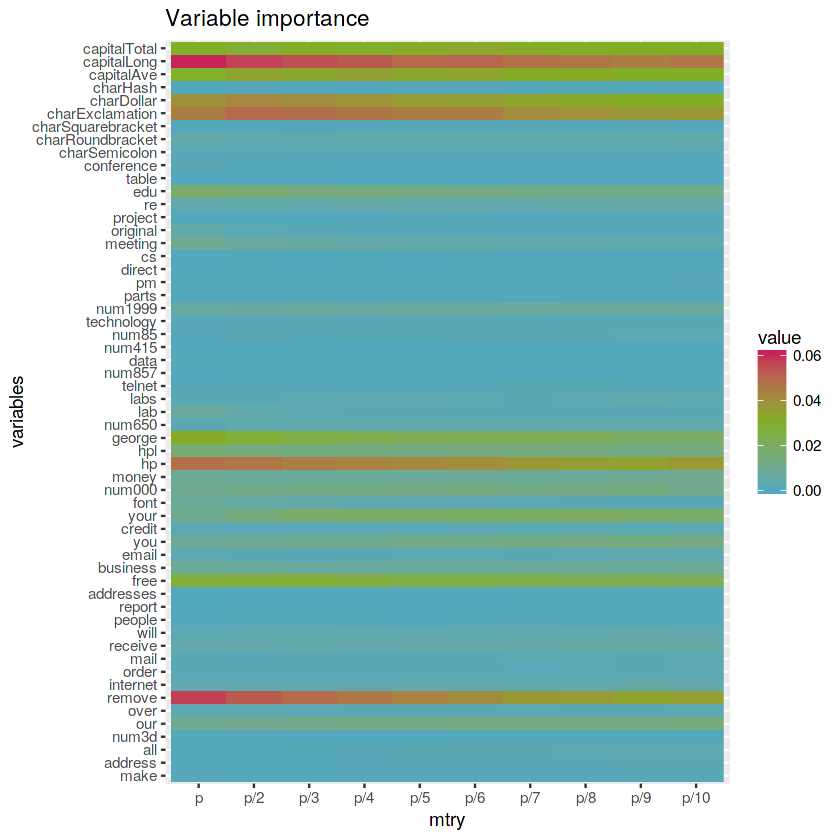

In [73]:
# Plot matrix
ggplot(reshape2::melt(varimp.matrix)) + 
geom_raster(aes(x = Var2, y = Var1, fill = value), interpolate = FALSE) + 
labs(x = "mtry", y = "variables", title = "Variable importance") + 
scale_fill_gradientn(colours = c(blue, green, red))

> The variables *capitalLong*, *charExclamation*, *capitalTotal*, *capitalAve*, *charDollar*, *hp* and *remove* seems to be important for all the Random Forest models with different `mtry` values. Also, higher variable importance values are related to higher `mtry` values.

## 5. Variable selection using random forests

### 5.1. Load the library **VSURF**

In [74]:
# Load library
library(VSURF)

In [540]:
# Variable Selection Using Random Forests documentation
# ?VSURF

### 5.2. Apply **VSURF** on a subset of 500 observations of the data table spam.app

In [80]:
# Subset spam data 
spam.app <- spam %>% sample_n(500)

In [142]:
# Apply VSURF
vsurf.spam <- VSURF(type ~ ., data = spam.app, ntree = 1000, parallel = TRUE)

Warning message in VSURF.formula(type ~ ., data = spam.app, ntree = 1000, parallel = TRUE):
“VSURF with a formula-type call outputs selected variables
which are indices of the input matrix based on the formula:
you may reorder these to get indices of the original data”

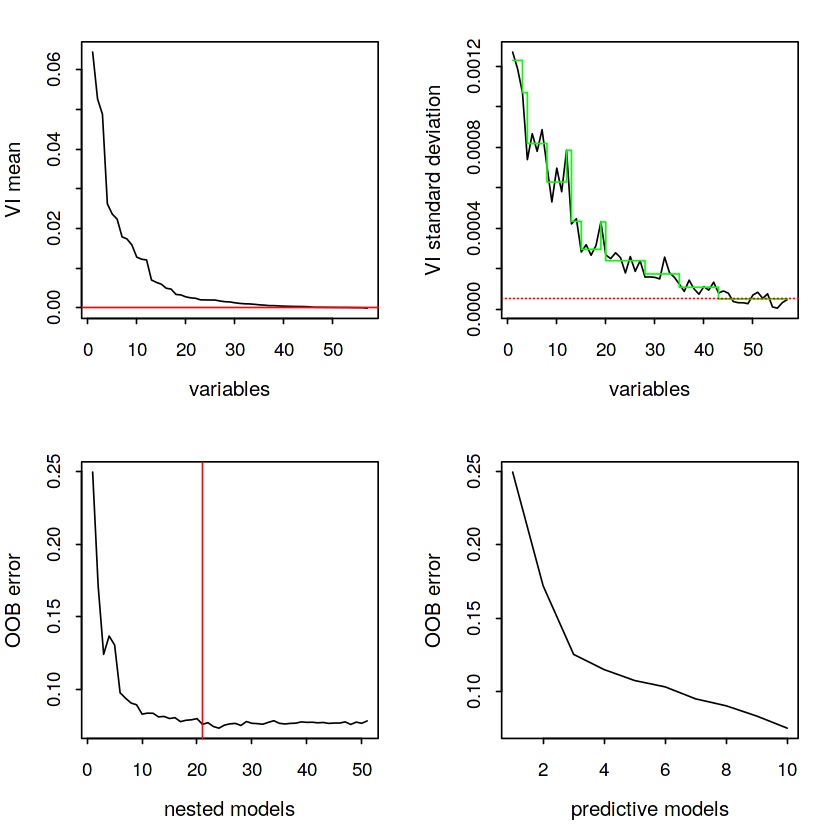

In [143]:
# Plot
plot(vsurf.spam, cex.axis = 1.1, cex.lab = 1.2)

> The top plots of the figure illustrate the Thresholding step and the bottom plots are associated with Interpretation and Prediction steps respectively.

### 5.3. Comment on the results of the different steps

In [144]:
# Summary results
summary(vsurf.spam)


 VSURF computation time: 3.1 mins 

 VSURF selected: 
	51 variables at thresholding step (in 23.9 secs)
	21 variables at interpretation step (in 1.6 mins)
	10 variables at prediction step (in 1 mins)

 VSURF ran in parallel on a PSOCK cluster and used 7 cores 


In [145]:
# Thresholding variables
kept1.app <- colnames(spam.app[vsurf.spam$varselect.thres])
removed1.app <- colnames(spam.app)[!(colnames(spam.app) %in% kept1.app)]

cat("Thresholding Step \n")
cat("> Removed variables: "); cat(paste0(removed1.app, ","))
cat("\n")
cat("> Kept variables: "); cat(paste0(kept1.app, ","))

Thresholding Step 
> Removed variables: num3d, report, parts, direct, table, charHash, type,
> Kept variables: charDollar, charExclamation, remove, hp, capitalLong, your, capitalTotal, capitalAve, our, george, free, num000, num1999, hpl, edu, receive, over, business, you, internet, data, email, will, original, technology, meeting, money, num85, re, order, num650, charRoundbracket, all, charSemicolon, lab, cs, address, addresses, conference, pm, labs, mail, charSquarebracket, credit, project, telnet, font, num857, num415, make, people,

> In the first step ("thresholding step") 7 irrelevant variables were eliminated and 51 variables were kept. 

In [150]:
# Interpretation variables
kept2.app <- colnames(spam.app[vsurf.spam$varselect.interp])
removed2.app <- colnames(spam.app)[!(colnames(spam.app) %in% kept2.app)]

cat("Interpretation Step \n")
cat("> Removed variables: "); cat(paste0(removed2.app, ","))
cat("\n")
cat("> Kept variables: "); cat(paste0(kept2.app, ","))

Interpretation Step 
> Removed variables: make, address, all, num3d, order, mail, will, people, report, addresses, email, credit, font, money, num650, lab, labs, telnet, num857, num415, num85, technology, parts, pm, direct, cs, meeting, original, project, re, table, conference, charSemicolon, charRoundbracket, charSquarebracket, charHash, type,
> Kept variables: charDollar, charExclamation, remove, hp, capitalLong, your, capitalTotal, capitalAve, our, george, free, num000, num1999, hpl, edu, receive, over, business, you, internet, data,

> In the second step ("interpretation step") 37 variables non related to the response for interpretation purpose were eliminated and 21 variables were kept. 

In [153]:
# Prediction variables
kept3.app <- colnames(spam.app[vsurf.spam$varselect.pred])
removed3.app <- colnames(spam.app)[!(colnames(spam.app) %in% kept3.app)]

cat("Prediction Step \n")
cat("> Removed variables: "); cat(paste0(removed3.app, ","))
cat("\n")
cat("> Kept variables: "); cat(paste0(kept3.app, ","))

Prediction Step 
> Removed variables: make, address, all, num3d, over, internet, order, mail, receive, will, people, report, addresses, free, business, email, you, credit, font, num000, money, hp, num650, lab, labs, telnet, num857, data, num415, num85, technology, parts, pm, direct, cs, meeting, original, project, re, edu, table, conference, charSemicolon, charRoundbracket, charSquarebracket, charHash, capitalLong, type,
> Kept variables: charDollar, charExclamation, remove, your, capitalTotal, capitalAve, our, george, num1999, hpl,

> In the third step ("prediction step") 48 redundant variables were eliminated for refining the prediction purpose and 10 variables were kept. 

> After performing the three steps variable selection procedure using the `VSURF` library we got 10 variables from the 57 initial total variables. 

### 5.4. Experiment with the parallel version based on the article on **VSURF**

- **Try VSURF with different number of forest grown (`nfor`) at each step and all its combinations**

In [244]:
# Combinations of different nfor
nfor <- data.frame("nfor.thres" = seq(10, 130, by = 30),
                   "nfor.interp" = seq(10, 130, by = 30),
                   "nfor.pred" = seq(10, 130, by = 30)) %>% expand(nfor.thres, nfor.interp, nfor.pred)

nfor.list <- split(bfor, seq(nrow(nfor)))

In [ ]:
# All combinations for the different nfor values in each step
list.nfor <- lapply(nfor.list, function(x) {
    message(paste0("\n Calculating VSURF with nfor.thres: ", x$nfor.thres,
                   ", nfor.interp.values: ", x$nfor.interp,
                   " and nfor.pred: ", x$nfor.pred, "."))
    
    VSURF(type ~ ., data = spam.app, 
          nfor.thres = x$nfor.thres, 
          nfor.interp.values = x$nfor.interp, 
          nfor.pred = x$nfor.pred,
          parallel = TRUE)
    })

In [462]:
# Create empty 3D matrix
array <- array(data = NA, dim = c(5, 5, 5), 
               dimnames = list(paste0("nfor.thres:", as.character(seq(10, 130, by = 30))), 
                               paste0("nfor.interp:", as.character(seq(10, 130, by = 30))), 
                               paste0("nfor.pred:", as.character(seq(10, 130, by = 30)))))

array.numberof.varselect.thres <- array
array.numberof.varselect.interp <- array
array.numberof.varselect.pred <- array

In [ ]:
# Fill empty 3D arrays with the number of variables kept on each step for all the combinations tested
lapply(1:length(nfor.list), function(w) {
    
    x <- which(seq(10, 130, by = 30) == nfor.list[[w]]$nfor.thres)
    y <- which(seq(10, 130, by = 30) == nfor.list[[w]]$nfor.interp)
    z <- which(seq(10, 130, by = 30) == nfor.list[[w]]$nfor.pred)
       
    array.numberof.varselect.thres[x, y, z] <<- length(list.nfor[[w]]$varselect.thres)
    array.numberof.varselect.interp[x, y, z] <<- length(list.nfor[[w]]$varselect.interp)
    array.numberof.varselect.pred[x, y, z] <<- length(list.nfor[[w]]$varselect.pred)
    
})

In [510]:
# Get integer vector values for each array
numberof.varselect.thres <- data.frame("values" = as.numeric(array.numberof.varselect.thres))
numberof.varselect.interp <- data.frame("values" = as.numeric(array.numberof.varselect.interp))
numberof.varselect.pred <- data.frame("values" = as.numeric(array.numberof.varselect.pred))

In [465]:
# Reshape the numberof.varselect data to make an histogram 
numberof.varselect <- numberof.varselect.thres %>% 
                        mutate(var = "varselect.thres") %>% 
                         select(var, values) %>% 
                            rbind(numberof.varselect.interp %>% 
                                  mutate(var = "varselect.interp") %>% 
                                  select(var, values)) %>%
                                    rbind(numberof.varselect.pred %>% 
                                        mutate(var = "varselect.pred") %>% 
                                          select(var, values))

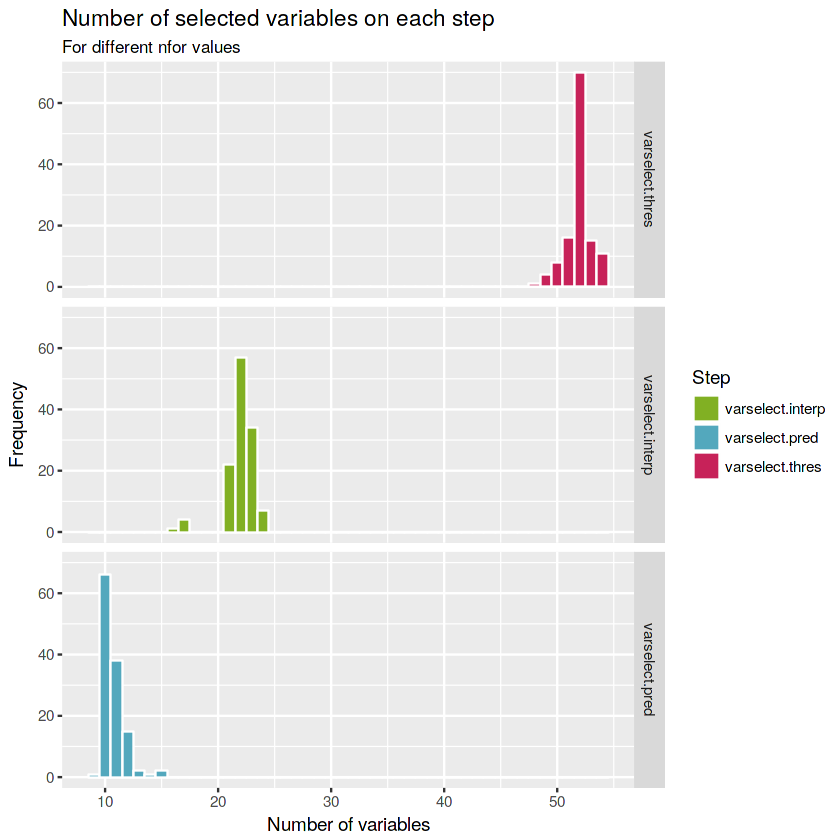

In [475]:
# Create histogram
ggplot(numberof.varselect) + 
geom_histogram(aes(x = values, 
                   fill = var), 
               color = "white", binwidth = 1) + 
labs(title = "Number of selected variables on each step", subtitle = "For different nfor values",
     x = "Number of variables", y = "Frequency") + 
scale_fill_manual(values = c(green, blue, red), name = "Step") + 
facet_grid(factor(var, levels = c("varselect.thres", "varselect.interp", "varselect.pred")) ~ .)

> The most frequent number of variables selected changing the number of grown forest (`nfor`) at each step for the first, second and third steps are 52, 22 and 10 total variables respectively. 

- **Check the number of variables selected in Step 1 - Threshold**

In [493]:
matrix_nfor.thresh <- reshape2::melt(array.numberof.varselect.thres[1,,]) %>% 
                        mutate(nfor.thres = "nfor.thres:10") %>% 
                            rbind(reshape2::melt(array.numberof.varselect.thres[2,,]) %>% 
                                    mutate(nfor.thres = "nfor.thres:40")) %>% 
                                        rbind(reshape2::melt(array.numberof.varselect.thres[3,,]) %>% 
                                                mutate(nfor.thres = "nfor.thres:70")) %>%
                                                    rbind(reshape2::melt(array.numberof.varselect.thres[4,,]) %>% 
                                                         mutate(nfor.thres = "nfor.thres:100")) %>% 
                                                            rbind(reshape2::melt(array.numberof.varselect.thres[5,,]) %>% 
                                                                    mutate(nfor.thres = "nfor.thres:130"))

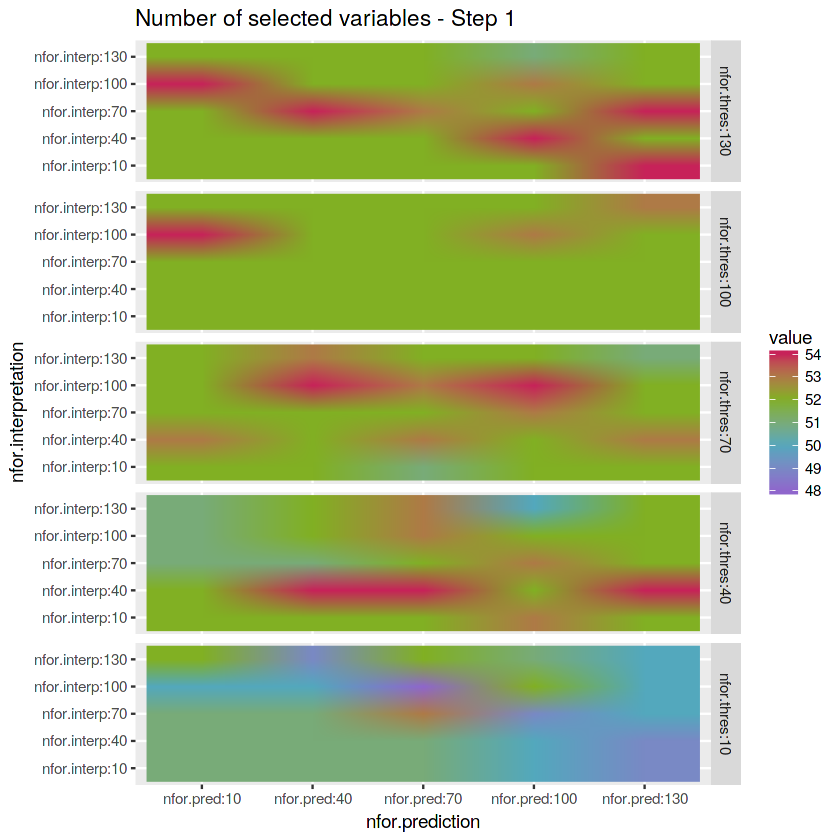

In [512]:
# Plot matrix
ggplot(matrix_nfor.thresh) + 
geom_raster(aes(x = Var2, y = Var1, fill = value), interpolate = TRUE) + 
labs(x = "nfor.prediction", y = "nfor.interpretation", title = "Number of selected variables - Step 1") + 
scale_fill_gradientn(colours = c(purple, blue, green, red)) + 
facet_grid(factor(nfor.thres, levels = c("nfor.thres:130",
                                         "nfor.thres:100",
                                         "nfor.thres:70",
                                         "nfor.thres:40",
                                         "nfor.thres:10")) ~ .)

- **Check the number of variables selected in Step 2 - Interpretation**

In [517]:
matrix_nfor.interpret <- reshape2::melt(array.numberof.varselect.thres[,1,]) %>% 
                        mutate(nfor.interp = "nfor.interp:10") %>% 
                            rbind(reshape2::melt(array.numberof.varselect.thres[,2,]) %>% 
                                    mutate(nfor.interp = "nfor.interp:40")) %>% 
                                        rbind(reshape2::melt(array.numberof.varselect.thres[,3,]) %>% 
                                                mutate(nfor.interp = "nfor.interp:70")) %>%
                                                    rbind(reshape2::melt(array.numberof.varselect.thres[,4,]) %>% 
                                                         mutate(nfor.interp = "nfor.interp:100")) %>% 
                                                            rbind(reshape2::melt(array.numberof.varselect.thres[,5,]) %>% 
                                                                    mutate(nfor.interp = "nfor.interp:130"))

In [511]:
save.image("data.RData")

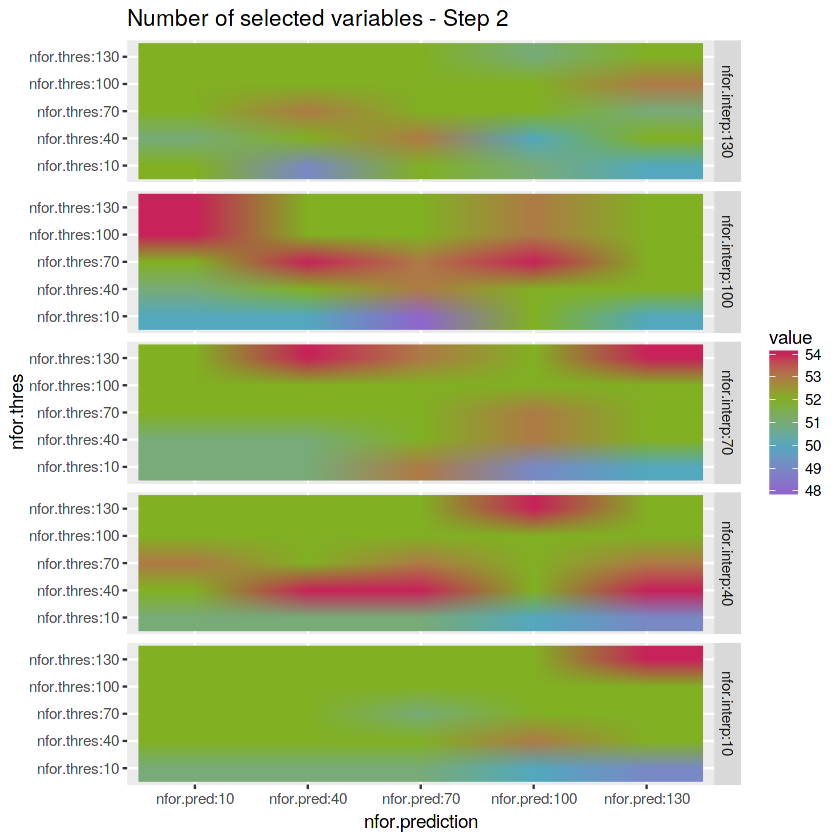

In [519]:
# Plot matrix
ggplot(matrix_nfor.interpret) + 
geom_raster(aes(x = Var2, y = Var1, fill = value), interpolate = TRUE) + 
labs(x = "nfor.prediction", y = "nfor.thres", title = "Number of selected variables - Step 2") + 
scale_fill_gradientn(colours = c(purple, blue, green, red)) + 
facet_grid(factor(nfor.interp, levels = c("nfor.interp:130",
                                         "nfor.interp:100",
                                         "nfor.interp:70",
                                         "nfor.interp:40",
                                         "nfor.interp:10")) ~ .)

- **Check the number of variables selected in Step 3 - Prediction**

In [524]:
matrix_nfor.pred <- reshape2::melt(array.numberof.varselect.thres[,,1]) %>% 
                        mutate(nfor.pred = "nfor.pred:10") %>% 
                            rbind(reshape2::melt(array.numberof.varselect.thres[,,2]) %>% 
                                    mutate(nfor.pred = "nfor.pred:40")) %>% 
                                        rbind(reshape2::melt(array.numberof.varselect.thres[,,3]) %>% 
                                                mutate(nfor.pred = "nfor.pred:70")) %>%
                                                    rbind(reshape2::melt(array.numberof.varselect.thres[,,4]) %>% 
                                                         mutate(nfor.pred = "nfor.pred:100")) %>% 
                                                            rbind(reshape2::melt(array.numberof.varselect.thres[,,5]) %>% 
                                                                    mutate(nfor.pred = "nfor.pred:130"))

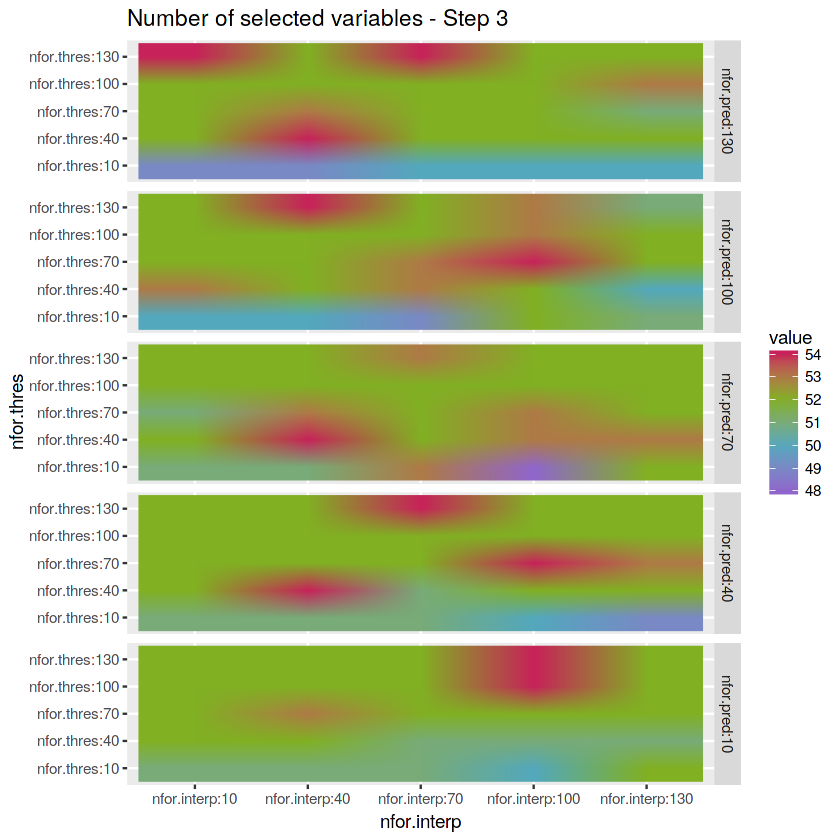

In [526]:
# Plot matrix
ggplot(matrix_nfor.pred) + 
geom_raster(aes(x = Var2, y = Var1, fill = value), interpolate = TRUE) + 
labs(x = "nfor.interp", y = "nfor.thres", title = "Number of selected variables - Step 3") + 
scale_fill_gradientn(colours = c(purple, blue, green, red)) + 
facet_grid(factor(nfor.pred, levels = c("nfor.pred:130",
                                          "nfor.pred:100",
                                          "nfor.pred:70",
                                          "nfor.pred:40",
                                          "nfor.pred:10")) ~ .)

In [528]:
# Save environment objects to file
save.image("data.RData")